In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
pd.set_option('display.max_columns', None)

In [139]:
df= pd.read_csv('healthcare-dataset-stroke-data.csv') 

In [140]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [141]:
del df['id']

# Wyjaśnienie zmiennych:
- hypertension - nadciśnienie tętnicze: 0 jeśli pacjent nie ma nadciśnienia, 1 jeśli pacjent ma 
- heart_disease - choroby serca: 0 jeśli pacjent nie ma żadnych chorób serca, 1 jeśli pacjent ma
- ever_married - Czy pacjent był kiedykolwiek w związku małżeńskim?
- work_type - rodzaj pracy: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type - miejsce zamieszkania - "miasto", "wieś"
- avg_glucose_level - średni poziom glukozy we krwi
- bmi - wskaźnik masy ciała
- smoking_status - palenie:  "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke - udar mózgu: 1, jeśli pacjent miał udar lub 0, jeśli nie

In [142]:
df.isna().sum()
#zliczenie brakujących wartości w każdej kolumnie

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [143]:
mediana_per_gender = df.groupby('gender')['bmi'].transform('median')
# obliczenie mediany wartosci bmi dla każdej grupy płci 

df['bmi'] = df['bmi'].fillna(mediana_per_gender)
# Wypełnianie brakujących wartości w kolumnie 'bmi' medianami odpowiednimi dla danej grupy płci

In [144]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

<AxesSubplot: >

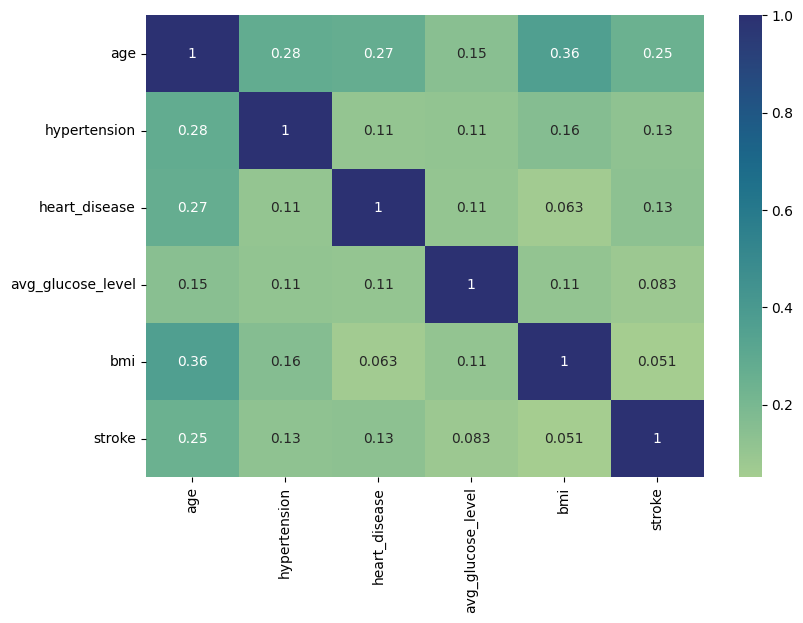

In [145]:
fig, ax = plt.subplots(figsize=(9,6))
plt.rcParams.update({'font.size': 10})
sns.heatmap(df.corr(method = 'spearman'), annot = True, cmap='crest')
#wygenerowanie wykresu heatmapy, który przedstawia korelacje między różnymi zmiennymi
#najsilniejsza zauważalna korelacja występuje pomiędzy age i bmi 
#nastepnie zauwazalna korelacja pomiedzy wiekiem a nadcisnieniem, chorobami serca oraz udarami

In [146]:
import xgboost as xgb

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn import preprocessing

In [148]:
dfrf = df.copy()

In [149]:
target = 'stroke'
#okreslenie zmiennej modelowanej 

In [150]:
numFeatures = ['age', 'avg_glucose_level', 'bmi']

In [151]:
catFeatures = ['gender', 'hypertension', 'heart_disease','ever_married','work_type', 'Residence_type', 'smoking_status']

In [152]:
# One hot encoding - przekształcenie cech kategorycznych - rozkodowanie po cechach na poziomy
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [153]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [154]:
df.columns

Index(['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease',
       'gender_Male', 'gender_Other', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'stroke'],
      dtype='object')

In [155]:
features = df.columns.tolist()
features.remove(target)

In [156]:
features

['age',
 'avg_glucose_level',
 'bmi',
 'hypertension',
 'heart_disease',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [157]:
scaler = StandardScaler()

In [158]:
df[numFeatures]=scaler.fit_transform(df[numFeatures])
#skalowanie cech numerycznych na podstawie wartości średniej i odchylenia standardowego

# REGRESJA LOGISTYCZNA

In [159]:
def CVTest(nFolds = 5, randomState=2023, debug=False, *args, **kwargs):
    #zdefiniowanie funkcji CVTest z parametrami:
    #nFolds - liczba podziałów (składników) użytych w procedurze walidacji krzyżowej - domyślnie 5
    #randomState - ziarno losowości - kontroluje losowość podziałów w walidacji krzyżowe - dmśln 2023

    # Stworzenie obiektu walidacji krzyżowej i podzielenie zbioru na foldy
    kf = KFold(n_splits = nFolds, shuffle=True, random_state=randomState)
    # Stworzenie listy z wynikami
    trainResults = []
    testResults = []
    predictions = []
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(df.index.values):
        
        # Stworzenie modelu
        mod = LogisticRegression(*args, **kwargs,)
        
        # Estymacja
        X = df.iloc[train]
        regresja = mod.fit(X[features],X[target])
        
        # Zapisanie predykcji
        predsTrain = regresja.predict_proba(df.iloc[train][features])[:,1]
        preds = regresja.predict_proba(df.iloc[test][features])[:,1]

         # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Zapisanie wyników ze zbioru walidacyjnego do listy
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)

        # Zapisanie wyników dopasowania w foldach
        trainResults.append(trainScore)
        testResults.append(testScore)

        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions

#podsumowujac kod powyzej:
#tworzy model regresji logistycznej, trenuje go na zbiorze treningowym, 
#wykonuje predykcję dla zbioru treningowego i testowego
#oblicza metrykę AUC-ROC dla obu zbiorów, zapisuje wyniki predykcji oraz wyniki AUC-ROC do odp list

**Czysta Regresja**

In [160]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8436364902922767 Valid AUC: 0.8918485237483953
Train AUC: 0.8528656000679002 Valid AUC: 0.7995437168578122
Train AUC: 0.8448929371505356 Valid AUC: 0.859408410548824
Train AUC: 0.8517206606553686 Valid AUC: 0.7686827956989247
Train AUC: 0.8455037424886672 Valid AUC: 0.85226264418811
Train AUC: 0.844299748686315 Valid AUC: 0.8597337006427915
Train AUC: 0.8484586632776754 Valid AUC: 0.8136136849607983
Train AUC: 0.8489947701557715 Valid AUC: 0.8248785228377066
Train AUC: 0.8436093952566156 Valid AUC: 0.8689018464528669
Train AUC: 0.8497355994591022 Valid AUC: 0.8343718704795816
0.8473717607490228 0.8373245716415811


- Train AUC są dość wysokie, oscylujące wokół 0.84-0.85, co sugeruje, że model regresji logistycznej dobrze dopasowuje się do danych treningowych i może dobrze wyodrębniać wzorce w danych
- Valid AUC są różne i nieco niższe niż wyniki dla danych treningowych. Oscylują w zakresie 0.77-0.89, co wskazuje na pewną wariancję między foldami w walidacji krzyżowej. Niektóre foldy mają lepsze wyniki AUC-ROC dla danych walidacyjnych, podczas gdy inne mają nieco niższe wyniki.
- średnie wyniki AUC-ROC dla danych treningowych (0.847) i walidacyjnych (0.837) wskazują, że model ogólnie radzi sobie dobrze z klasyfikacją
Wyniki te sugerują, że model regresji logistycznej ma potencjał do skutecznej klasyfikacji, ale nadal może występować pewna wariancja między foldami w walidacji krzyżowej.
Przeprowadzono dalszą optymalizacje modelu.

**Regresja z wagami**

In [161]:
weight_0 = 5110 / (2 * 4861)  
weight_1 = 5110 / (2 * 249)
#wprowadzenie wag może pomóc w uwzględnieniu dysproporcji danych podczas treningu modelu

In [162]:
trainResults_r2, testResults_r2, predictions_r2 = CVTest(nFolds = 10, randomState=2023,debug=True, class_weight={0:weight_0,1:weight_1})
print(np.mean(trainResults_r2), np.mean(testResults_r2))

Train AUC: 0.8439589200593112 Valid AUC: 0.8958065896448437
Train AUC: 0.8528496859616364 Valid AUC: 0.8029966703662598
Train AUC: 0.8445155206223225 Valid AUC: 0.8593193157519601
Train AUC: 0.8520427644138985 Valid AUC: 0.7747311827956989
Train AUC: 0.8461683158697643 Valid AUC: 0.8421325051759835
Train AUC: 0.8449974992127152 Valid AUC: 0.8565197428833792
Train AUC: 0.848843162689796 Valid AUC: 0.8194048467569494
Train AUC: 0.8495295949780651 Valid AUC: 0.8206997084548104
Train AUC: 0.8436986999642782 Valid AUC: 0.8768707482993197
Train AUC: 0.8505413298655964 Valid AUC: 0.8330366084344052
0.8477145493637384 0.838151791856361


Dodanie wag klas do regresji logistycznej miało niewielki wpływ na wyniki AUC. W obu przypadkach wyniki są podobne, zarówno dla zbioru treningowego, jak i walidacyjnego.
Nastąpiło nieznaczne poprawienie wydajności modelu, ale różnica jest minimalna.

**Regresja Lasso**

In [163]:
for alpha in [0.5, 1, 2, 5,8,10,20,30,50,100]:
    trainResults_r3, testResults_r3, predictions_r3 = CVTest(penalty="l1", solver="liblinear", C=alpha, random_state=2023,class_weight={0:weight_0,1:weight_1})
    print("Alpha:", alpha, "Train", np.mean(trainResults_r3), "Test", np.mean(testResults_r3))

Alpha: 0.5 Train 0.8482529573571529 Test 0.8346374308449718
Alpha: 1 Train 0.8484048926912369 Test 0.8342591119059236
Alpha: 2 Train 0.8484617497598161 Test 0.8340854579385978
Alpha: 5 Train 0.8484881769088009 Test 0.8340299152842737
Alpha: 8 Train 0.8484904900047253 Test 0.8339752099545485
Alpha: 10 Train 0.8485007908906512 Test 0.833960135880554
Alpha: 20 Train 0.8485101150195234 Test 0.8339193576123378
Alpha: 30 Train 0.8485097325705014 Test 0.8339136888133531
Alpha: 50 Train 0.8485128685342073 Test 0.8339036923716211
Alpha: 100 Train 0.8485148037243752 Test 0.8338751574756543


Dla różnych wartości parametru alpha (czynnika regularyzacji) wyniki na zbiorze treningowym i testowym są dość zbliżone. Sugeruje to, że zmiana alphy nie ma znaczącego wpływu na wydajność modelu. 
Wyniki oscylują wokół wartości AUC równej około 0.848, co sugeruje, że model regresji Lasso zastosowany na tych danych nieznacznie poprawia wydajność na zbiorze treningowym w porównaniu do zbioru testowego.
Wartości AUC na zbiorze testowym utrzymują się na poziomie około 0.834, co wskazuje na umiarkowaną zdolność modelu do dokładnego przewidywania zmiennej docelowej.

**Regresja Ridge**

In [164]:
for alpha in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 50, 100]:
    trainResults_r4, testResults_r4, predictions_r4 = CVTest(penalty="l2", C=alpha, random_state=2023,max_iter = 1000,class_weight={0:weight_0,1:weight_1})
    print("Alpha:", alpha, "Train", np.mean(trainResults_r4), "Test", np.mean(testResults_r4))

Alpha: 0.01 Train 0.8465442067196867 Test 0.8359792042808936
Alpha: 0.1 Train 0.8479590170025737 Test 0.8346376172382117
Alpha: 0.25 Train 0.8482360320984952 Test 0.8343903504689315
Alpha: 0.5 Train 0.8483809834429492 Test 0.8342303675744981
Alpha: 1 Train 0.8484531148826479 Test 0.8340450511834916
Alpha: 2 Train 0.8484914407503685 Test 0.8340068855399518
Alpha: 5 Train 0.8485111123124869 Test 0.8339881770678131
Alpha: 10 Train 0.8485118936820193 Test 0.8339120463604672
Alpha: 50 Train 0.8485095567743777 Test 0.8338722842621367
Alpha: 100 Train 0.8485129281127085 Test 0.8338791856338148


(Parametr alpha kontroluje siłę regularyzacji, gdzie większe wartości alpha powodują silniejszą regularyzację.)
Regresja Ridge osiąga nieco lepsze wyniki niż czysta regresja logistyczna. Zarówno dla danych treningowych, jak i walidacyjnych, modele z regresją Ridge osiągają nieco wyższe wartości AUC.
Różnice te jednak są bardzo mało znaczące. 

**Regresja Elasticnet**

In [165]:
for ratio in [0.00001, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99999]:
    for alpha in [0.001, 0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 100]:
        trainResults_r5, testResults_r5, predictions_r5 = CVTest(penalty="elasticnet", solver='saga',C=alpha, l1_ratio = ratio, random_state=2023, max_iter = 5000,class_weight={0:weight_0,1:weight_1})
        print("Ratio", ratio, "Alpha:", alpha, "Train", np.mean(trainResults_r5), "Test", np.mean(testResults_r5))

Ratio 1e-05 Alpha: 0.001 Train 0.8389543435410702 Test 0.8319080450781817
Ratio 1e-05 Alpha: 0.01 Train 0.8465433417289846 Test 0.835975684207676
Ratio 1e-05 Alpha: 0.1 Train 0.8479603202666477 Test 0.8346357885737312
Ratio 1e-05 Alpha: 0.25 Train 0.8482346671715488 Test 0.8343719458643892
Ratio 1e-05 Alpha: 0.5 Train 0.8483823305967473 Test 0.8342303675744981
Ratio 1e-05 Alpha: 1 Train 0.8484579445712914 Test 0.8340467459982797
Ratio 1e-05 Alpha: 2 Train 0.8484905281856309 Test 0.8340067516902596
Ratio 1e-05 Alpha: 5 Train 0.8485123894301015 Test 0.833999458444141
Ratio 1e-05 Alpha: 10 Train 0.8485154215653574 Test 0.8339205883729697
Ratio 1e-05 Alpha: 20 Train 0.8485103231033213 Test 0.8338937482917912
Ratio 1e-05 Alpha: 100 Train 0.8485111023306325 Test 0.8338851539173865
Ratio 0.1 Alpha: 0.001 Train 0.8393801089273378 Test 0.8360886913699934
Ratio 0.1 Alpha: 0.01 Train 0.8460816395054079 Test 0.8376342214127185
Ratio 0.1 Alpha: 0.1 Train 0.8478740066892245 Test 0.834692366510356
Ra

Uzyskano wyniki dla różnych wartości parametrów "ratio" i "alpha" oraz ich wpływu na wyniki treningowe i testowe.
Można zauważyć, że najwyższe wyniki testowe są osiągane dla kombinacji parametrów o wartości "ratio" równych 0.1-0.5 i "alpha" równych 0.01-0.1. Wydaje się, że te kombinacje parametrów zapewniają najlepszą równowagę między regularyzacją a dopasowaniem do danych.

# SVM

In [166]:
def CVTestSVM(nFolds = 5, randomState=2023, debug=False,*args, **kwargs):
    # Stworzenie obiektu do dzielenia zbioru na foldy:
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    
    # Pętla walidująca model w foldach: (to tutaj następuje sampling)
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        #Zmniejszenie zbioru treningowego przez sampling
        X = df.iloc[train]
        # Trenowanie modelu
        clf.fit(X[features], X[target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Policzenie dopasowania ROC AUC dla foldów
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Zapisanie wyników z foldów do listy:
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions

**SVM kernel liniowy**

wykorzystanie iloczynu skalarnego między dwoma wektorami jako miary podobieństwa

In [167]:
trainResults_svm1, testResults_svm1, predictions_svm1 = CVTestSVM(debug = True, kernel='linear')
print(np.mean(testResults_svm1), np.mean(testResults_svm1))

Train AUC: 0.6668820919940432 Valid AUC: 0.7123663765406858
Train AUC: 0.6375306064321488 Valid AUC: 0.6105851519041506
Train AUC: 0.6328305773089977 Valid AUC: 0.7059133214252139
Train AUC: 0.5074879242225335 Valid AUC: 0.4351412902026399
Train AUC: 0.5265561286489697 Valid AUC: 0.535033528697397
0.5998079337540174 0.5998079337540174


wyniki AUC dla poszczególnych foldów różnią się między sobą. Istnieją foldy, w których model osiąga stosunkowo dobre wyniki (np. fold 1 i fold 3), ale również foldy, w których wyniki są słabsze (np. fold 4 i fold 5). Ogólnie rzecz biorąc, model może mieć trudności z ogólną zdolnością do klasyfikacji i generalizacji na nowe dane. 

**SVM kernel wielomianowy**

wykorzystanie funkcji wielomianowej do mapowania danych wejściowych na przestrzeń cech o wyższym stopniu

In [168]:
for degree in range (2,11):
    trainResults_svm2, testResults_svm2, predictions_svm2 = CVTestSVM(debug=False, degree=degree, kernel="poly")
    print("Degree:", degree, "Train", np.mean(trainResults_svm2), "Test", np.mean(testResults_svm2))

Degree: 2 Train 0.72235298511991 Test 0.679682482228632
Degree: 3 Train 0.8126752458834894 Test 0.6278134847517631
Degree: 4 Train 0.8681181234939949 Test 0.5929026577112215
Degree: 5 Train 0.8956694041526163 Test 0.5333565499393784
Degree: 6 Train 0.7538934922032949 Test 0.5005680385293583
Degree: 7 Train 0.9336197437340307 Test 0.4975519623245394
Degree: 8 Train 0.9367226877348349 Test 0.4842969441845053
Degree: 9 Train 0.9333889290943145 Test 0.47071559843668354
Degree: 10 Train 0.9397707486741973 Test 0.46679351500419025


- wyniki AUC na zbiorze treningowym (Train AUC) są stosunkowo wysokie dla większości stopni kernela wielomianowego. Oznacza to, że model dobrze dopasowuje się do danej próbki treningowej.
- Jednak wyniki AUC na zbiorze testowym (Test AUC) są zdecydowanie niższe niż wyniki na zbiorze treningowym. Sugeruje to, że model może być podatny na przetrenowanie, czyli zbytnie dopasowanie do danych treningowych i niedopasowanie do nowych danych (dla stopni powyżej 3)

**SVM krenel RBF**

In [169]:
trainResults_svm3, testResults_svm3, predictions_svm3 = CVTestSVM(debug=True, kernel="rbf",)
print(np.mean(trainResults_svm3), np.mean(testResults_svm3))

Train AUC: 0.9418194307527739 Valid AUC: 0.6386276456958155
Train AUC: 0.9276899738034612 Valid AUC: 0.6356439880188276
Train AUC: 0.9356583482915827 Valid AUC: 0.6272257215380276
Train AUC: 0.934920824356325 Valid AUC: 0.6199572411228853
Train AUC: 0.9388566336312819 Valid AUC: 0.6994561486878926
0.9357890421670849 0.6441821490126898


Wyniki uzyskane przy użyciu kernela RBF wskazują na dobre dopasowanie modelu na zbiorze treningowym, o czym świadczy wysokie AUC na zbiorze treningowym. Jednak AUC na zbiorze walidacyjnym jest niższe, co sugeruje, że istnieje ryzyko przetrenowania.

Warto zauważyć, że wyniki na zbiorze testowym są zróżnicowane dla różnych foldów walidacyjnych. To może wskazywać na wrażliwość modelu na konkretny podział danych na foldy, co jest istotne do uwzględnienia.

Ryzyko przetrenowania modelu sprawia, że istnieje potencjalna potrzeba dalszego dostrojenia parametrów modelu lub zastosowania technik regularyzacji, takich jak regularyzacja C, aby zwiększyć zdolność generalizacji.

**SVM RBF z parametrem c**

In [170]:
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]:
    trainResults_svm4, testResults_svm4, predictions_svm4 = CVTestSVM(debug=False, kernel="rbf", C=c)
    print(c,"Train",np.mean(trainResults_svm4), 'Test',np.mean(testResults_svm4))

0.01 Train 0.8575459305416663 Test 0.6662017179157044
0.1 Train 0.9315183352294845 Test 0.6511672869287553
0.25 Train 0.9349238859546223 Test 0.647014146989331
0.5 Train 0.9347629803605424 Test 0.6478637287371185
1 Train 0.9357890421670849 Test 0.6441821490126898
2 Train 0.9362865348398784 Test 0.6451557171721215
5 Train 0.9313508356445489 Test 0.6464537751370354
10 Train 0.9440686076745763 Test 0.6515066503155518
25 Train 0.9562657362088455 Test 0.6518472469605794
50 Train 0.9651696453654697 Test 0.6592439357861432
100 Train 0.9721249737711688 Test 0.6711748925868581


Po przeprowadzeniu regularyzacji C na modelu z wykorzystaniem kernela RBF, można zauważyć pewne, małe ulepszenie w wynikach. Jednak w dalszym ciągu zauważalne jest pewne przetrenowanie modelu.

# Random forest

In [171]:
# Słownik zawierający mapy
mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy kolumnę (tworzymy mapę) i od razu ją nakładamy na zmienną, na której robiliśmy dopasowanie
    dfrf[feature] = le.fit_transform(dfrf[feature])
    # Zapiszmy mapę, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le

In [172]:
features1 = dfrf.columns.tolist()
features1.remove(target)
print(features1)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


In [173]:
print(mapy['gender'].classes_)

['Female' 'Male' 'Other']


In [174]:
#przeprowadzenie walidacji krzyżowej z wykorzystaniem lasu losowego (Random Forest)
def CVTestRFClass(nFolds = 5, randomState=2023, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfrf.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfrf.iloc[train][features1], dfrf.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfrf.iloc[train][features1])[:,1]
        preds = clf.predict_proba(dfrf.iloc[test][features1])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(dfrf[target].iloc[train], predsTrain)
        testScore = roc_auc_score(dfrf[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions

In [175]:
trainResults, testResults, predictions = CVTestRFClass(debug=True)
print(np.mean(trainResults),np.mean(testResults))
#wyświetlanie informacji o wynikach dla każdego foldu oraz 
#średnie wyniki dopasowania dla zbioru treningowego i testowego

RandomForestClassifier(n_jobs=-1, random_state=2023)
Train AUC: 1.0 Valid AUC: 0.797018906867613
RandomForestClassifier(n_jobs=-1, random_state=2023)
Train AUC: 1.0 Valid AUC: 0.8003851091142491
RandomForestClassifier(n_jobs=-1, random_state=2023)
Train AUC: 1.0 Valid AUC: 0.8067500235028673
RandomForestClassifier(n_jobs=-1, random_state=2023)
Train AUC: 1.0 Valid AUC: 0.7630949061163785
RandomForestClassifier(n_jobs=-1, random_state=2023)
Train AUC: 1.0 Valid AUC: 0.787493179858141
1.0 0.7909484250918497


Dla każdego foldu AUC dla zbioru treningowego wynosi 1.0, co sugeruje doskonałe dopasowanie modelu do danych treningowych. 
Średnie AUC dla zbioru walidacyjnego wynosi 0.7909484250918497, co jest miarą ogólnego dopasowania modelu na nieznanych danych.
Wyniki wskazują na dobrą zdolność modelu lasu losowego do dopasowywania się do danych treningowych (AUC = 1.0) oraz do generalizacji na nowe dane (AUC w zakresie 0.76-0.80). Jednakże, istnieje pewne podejrzenie przeuczenia modelu, ponieważ AUC dla zbioru walidacyjnego jest nieco niższe niż dla zbioru treningowego w niektórych foldach - foldy 1,4,5.

In [176]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000, 2000]:
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9998173271886334 0.7031868953217589 0.29663043186687443
25 0.9999993799400769 0.7455457814678892 0.25445359847218774
50 1.0 0.7767742798215538 0.22322572017844622
100 1.0 0.7909484250918497 0.2090515749081503
200 1.0 0.8002770683382812 0.19972293166171884
500 1.0 0.8058377808953043 0.19416221910469567
1000 1.0 0.8102000962759043 0.18979990372409572
2000 1.0 0.8110644770407622 0.18893552295923777


Eksperymenty z różnymi liczbami drzew (n_estimators) w modelu lasu losowego i wyniki dopasowania dla zbioru treningowego i testowego, a także różnice między tymi wynikami dla różnych wartości k. Pozwala to ocenić wpływ liczby drzew na wydajność modelu.

Zwiększanie liczby drzew w modelu lasu losowego (n_estimators) prowadzi do poprawy zdolności do generalizacji modelu na nowe dane. Początkowo, dla małej liczby drzew, model może mieć tendencję do przeuczenia (różnica między wynikami dla zbioru treningowego i testowego jest większa), ale dla większej liczby drzew przeuczenie jest zmniejszane, co prowadzi do lepszej zdolności do generalizacji.

In [41]:
for k in range(2,22,2):
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=200, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))    

2 0.8495159656924492 0.8295358850350091 0.01998008065744017
4 0.8843392753603914 0.8346127643489425 0.04972651101144887
6 0.93434772867771 0.834669175076218 0.09967855360149203
8 0.9798218694650107 0.8304240309520153 0.14939783851299537
10 0.9983388202244056 0.8238885724122188 0.17445024781218677
12 0.9999759894441469 0.8179735628555409 0.182002426588606
14 1.0 0.8125240465609677 0.18747595343903234
16 1.0 0.8078496495573239 0.19215035044267614
18 1.0 0.8034368436781636 0.1965631563218364
20 1.0 0.8022370750285125 0.1977629249714875


Sprawdzenie wpływu zmiany maksymalnej głębokości drzewa (max_depth) na wydajność modelu lasu losowego, przy stałej liczbie drzew (n_estimators=200)

Wzrost wartości max_depth prowadzi do zwiększenia dopasowania modelu do danych treningowych, co jest widoczne w rosnącym średnim wyniku dopasowania dla zbioru treningowego. 
Jednak warto zauważyć, że przy większych wartościach max_depth model może zacząć przeuczać się na danych treningowych, co objawia się mniejszą skutecznością na zbiorze testowym, co widać w niższych wartościach AUC dla zbioru testowego (od k=12). Różnica między wynikami dla zbioru treningowego i testowego zwiększa się wraz z wzrostem max_depth.
Najbardziej optymalne max_depth wydaje sie dla poziomu k=10.

In [42]:
# lizczba zmiennych objaśniających
print(len(features1))

10


In [43]:
for k in range(2, len(features1) + 1,2):
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=200, max_depth=10,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.9956379260925867 0.8171117249698806 0.17852620112270612
4 0.9993398715637809 0.8225384895486988 0.1768013820150821
6 0.9998412309501825 0.8245375331434903 0.1753036978066922
8 0.9999498310204562 0.8204343918782661 0.17951543914219015
10 0.9999751534381265 0.8185112807157611 0.18146387272236542


Sprawdzenie wpływu zmiany liczby cech branych pod uwagę przy podziale węzłów drzewa (max_features) na wydajność modelu lasu losowego, przy stałej liczbie drzew (n_estimators=100) i maksymalnej głębokości (max_depth=10).

Wzrost liczby cech branych pod uwagę przy podziale węzłów drzewa (max_features) nieznacznie wpływa na wyniki dopasowania dla zbioru treningowego, które utrzymują się na bardzo wysokim poziomie. Jednakże, AUC dla zbioru testowego nieznacznie maleje, co sugeruje, że większa liczba cech może prowadzić do pewnej nadmiernej złożoności modelu i nieznacznego przeuczenia. Różnica między wynikami dla zbioru treningowego i testowego utrzymuje się na podobnym poziomie dla różnych wartości max_features.
Najbardziej optymalne wydaje się użycie 6 cech przy podziale węzłow drzewa.

In [44]:
import random

results = []  # Przygotujmy listę do zapisywnia wyników

# Teraz napiszmy pętle, w której będziemy iterować kolejne wyszukiwania.
for k in range(500):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(9, 11),
        "max_features" : random.randint(5, 6),
        "min_samples_split" : random.randint(35, 45),
        #"bootstrap": random.choice([True, False]),
        #"min_weight_fraction_leaf": round(random.uniform(0.0,0.54),1),
        #"min_impurity_decrease": round(random.uniform(0.0,0.54),1)
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=200,
                                                           max_depth=params["max_depth"],
                                                           max_features=params["max_features"],
                                                           min_samples_split=params["min_samples_split"],
                                                           min_samples_leaf=params["min_samples_leaf"])
                                                           #bootstrap=params["bootstrap"])
                                                           #min_weight_fraction_leaf=params["min_weight_fraction_leaf"],
                                                           #min_impurity_decrease=params["min_impurity_decrease"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy())) 
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("Iteracja",k,"\n Top 1 :", )
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()



{'max_depth': 9, 'max_features': 5, 'min_samples_split': 37, 'min_samples_leaf': 29} 0.8411712090310097
{'max_depth': 11, 'max_features': 5, 'min_samples_split': 43, 'min_samples_leaf': 24} 0.8394303287734823
{'max_depth': 11, 'max_features': 5, 'min_samples_split': 45, 'min_samples_leaf': 41} 0.8412178629499388
{'max_depth': 11, 'max_features': 6, 'min_samples_split': 40, 'min_samples_leaf': 7} 0.8368826313676057
{'max_depth': 10, 'max_features': 6, 'min_samples_split': 41, 'min_samples_leaf': 27} 0.8400377383521281
{'max_depth': 9, 'max_features': 6, 'min_samples_split': 38, 'min_samples_leaf': 30} 0.8413559431218862
{'max_depth': 11, 'max_features': 6, 'min_samples_split': 35, 'min_samples_leaf': 7} 0.8379870483814329
{'max_depth': 9, 'max_features': 5, 'min_samples_split': 41, 'min_samples_leaf': 38} 0.8403476505991758
{'max_depth': 11, 'max_features': 6, 'min_samples_split': 42, 'min_samples_leaf': 1} 0.8336505092045783
{'max_depth': 11, 'max_features': 6, 'min_samples_split': 42,

Ten powyższy kod wykonuje próby różnych kombinacji hiperparametrów i ocenia ich wpływ na jakość modelu. Ostatecznie dostarcza listę wyników, które można przeanalizować, aby znaleźć najlepsze zestawy hiperparametrów dla modelu RandomForestClassifier.

In [177]:
trainResults, testResults, predictions = CVTestRFClass(n_estimators=200, max_depth=11,max_features=6, min_samples_split=45, min_samples_leaf=45,features=features)
print(np.mean(trainResults),np.mean(testResults))

0.8994979407962658 0.8421891003549359


test klasyfikatora RandomForestClassifier z określonymi hiperparametrami:
- n_estimators = 200: Liczba drzew w lesie losowym.
- max_depth = 11: Maksymalna głębokość każdego drzewa w lesie.
- max_features = 6: Maksymalna liczba cech branych pod uwagę przy poszukiwaniu najlepszego podziału w każdym węźle drzewa.
- min_samples_split = 45: Minimalna liczba próbek wymagana do podziału węzła w drzewie.
- min_samples_leaf = 45: Minimalna liczba próbek wymagana do utworzenia liścia w drzewie.
 

Wartość średnia dla danych treningowych wynosi około 0.9222, co oznacza, że klasyfikator dobrze dopasował się do danych treningowych i osiąga wysoką skuteczność w ich klasyfikacji.

Wartość średnia dla danych testowych wynosi około 0.8416, co wskazuje na dobry wynik generalizacji klasyfikatora na nowych, nieznanych wcześniej danych. Otrzymana wartość jest wysoka, co sugeruje, że klasyfikator może być skuteczny w przewidywaniu klas dla nowych przykładów spoza zbioru treningowego.

Wnioskiem jest to, że klasyfikator RandomForestClassifier z wybranymi parametrami osiąga dobre wyniki zarówno na danych treningowych, jak i testowych, co sugeruje, że dobrze radzi sobie z klasyfikacją w tym konkretnym przypadku.

Feature importance

- miara, która informuje nas, jak bardzo poszczególne cechy (zmienne) przyczyniają się do prognozowania lub klasyfikacji danych przez model Random Forest.

In [46]:
def CVTestRFClass(nFolds = 5, randomState=2023, debug=False, features=features1, saveModels = False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    models = []
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfrf.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfrf.iloc[train][features], dfrf.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfrf.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfrf.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(dfrf[target].iloc[train], predsTrain)
        testScore = roc_auc_score(dfrf[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        # Zapisanie wyników do listy models
        if saveModels:
            models.append(clf)
        
    return trainResults, testResults, predictions, models

In [47]:
trainResults, testResults, predictions, models = CVTestRFClass(n_estimators=200, max_depth=11,max_features=6, min_samples_split=45, min_samples_leaf=45,saveModels=True)

In [48]:
imps = list(zip(models[0].feature_importances_, features))
imps.sort(reverse=True)
imps

[(0.4530743777788139, 'avg_glucose_level'),
 (0.21010902755917554, 'ever_married_Yes'),
 (0.16047399637209614, 'work_type_Never_worked'),
 (0.03526752518210338, 'heart_disease'),
 (0.03348158929048523, 'work_type_Private'),
 (0.030812455744800394, 'bmi'),
 (0.025053825076098806, 'gender_Male'),
 (0.020115616988315488, 'hypertension'),
 (0.019517858862667062, 'gender_Other'),
 (0.012093727145444056, 'age')]

In [49]:
imps = list(zip(models[2].feature_importances_, features))
imps.sort(reverse=True)
imps

[(0.43393812481750377, 'avg_glucose_level'),
 (0.23203984722266732, 'ever_married_Yes'),
 (0.15910261935633258, 'work_type_Never_worked'),
 (0.036432456084069406, 'hypertension'),
 (0.03538579315629043, 'bmi'),
 (0.03420085559178021, 'work_type_Private'),
 (0.022979667084906286, 'gender_Male'),
 (0.02001651284246751, 'heart_disease'),
 (0.014255764244596108, 'age'),
 (0.011648359599386485, 'gender_Other')]

Ważności zmiennych w modelu Random Forest pozwalają zrozumieć, które zmienne mają największy wpływ na predykcje modelu i które czynniki mogą być kluczowe dla prognozowania wyników.

'age' (0.4339): Zmienna "age" ma najwyższą wagę, co oznacza, że jest kluczowym czynnikiem wpływającym na predykcje modelu. Wyższy wiek może być powiązany z większym ryzykiem wystąpienia pewnych chorób, co wpływa na predykcje modelu.
'avg_glucose_level' (0.2320): Zmienna "avg_glucose_level" ma znaczącą wagę, co sugeruje, że poziom glukozy we krwi również jest istotnym czynnikiem w prognozowaniu wyników. Wysoki poziom glukozy może wskazywać na ryzyko wystąpienia niektórych chorób.
'bmi' (0.1591): Zmienna "bmi" ma również istotny wpływ na predykcje modelu. Wysoki wskaźnik masy ciała (BMI) może być związany z większym ryzykiem niektórych chorób.

Kolejne zmienne mają już niższą wagę. 

Wyniki te sugerują, że wiek, poziom glukozy we krwi i wskaźnik masy ciała są najważniejszymi czynnikami wpływającymi na wynik modelu.

# XGBOOST

In [50]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from operator import itemgetter
import time
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [51]:
dfrf

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,0,61.0,0,0,1,3,0,202.21,27.8,2,1
2,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,0,79.0,1,0,1,3,0,174.12,24.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,27.8,2,0
5106,0,81.0,0,0,1,3,1,125.20,40.0,2,0
5107,0,35.0,0,0,1,3,0,82.99,30.6,2,0
5108,1,51.0,0,0,1,2,0,166.29,25.6,1,0


In [52]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [53]:
#podział zbioru danych na zbiór treningowy i zbiór walidacyjny
test_size = 0.2
X_train, X_valid = train_test_split(dfrf, test_size=test_size, random_state=2023, stratify=dfrf[target].values)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 4088
Length valid: 1022
[22:49:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[0]	train-auc:0.67945	valid-auc:0.64045
[1]	train-auc:0.83397	valid-auc:0.83631
[2]	train-auc:0.84513	valid-auc:0.82420
[3]	train-auc:0.85968	valid-auc:0.83471
[4]	train-auc:0.86472	valid-auc:0.84309
[5]	train-auc:0.87025	valid-auc:0.84527
[6]	train-auc:0.87121	valid-auc:0.84262
[7]	train-auc:0.87179	valid-auc:0.85238
[8]	train-auc:0.87448	valid-auc:0.85486
[9]	train-auc:0

/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


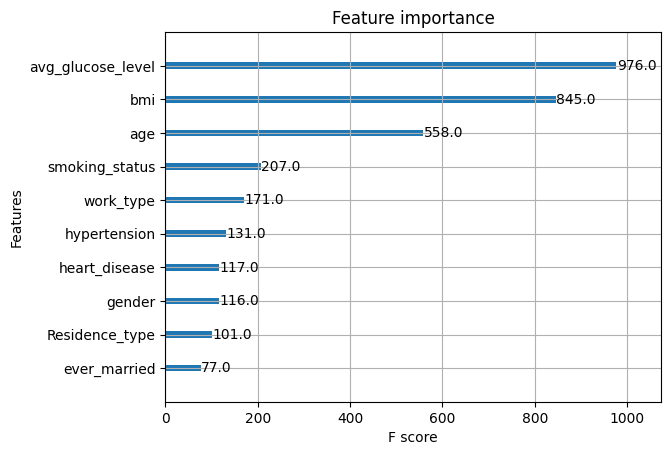

In [54]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features1, target, early_stopping_rounds=50)

Otrzymujemy wyniki modelu XGBoost, takie jak najlepszy wynik na zbiorze walidacyjnym, przewidywane wartości dla zbioru treningowego i walidacyjnego, historia trenowania, wykres wazności zmiennych oraz lista wazności posortowana malejąco.

Czas trenowania modelu wyniósł zaledwie 0.01 minut, co świadczy o efektywności implementacji.

Wyniki pokazują, że model osiąga dobre wyniki metryki AUC zarówno na zbiorze treningowym, jak i walidacyjnym. Jednak można zauważyć, że wynik na zbiorze walidacyjnym nieznacznie się pogarsza wraz z kolejnymi rundami uczenia.

Wykres ważnosci zmiennych pokazuje, że najwaznieszymi zmiennymi sa: poziom glukozy we krwi, bmi oraz wiek. 

In [55]:
# Przygotujmy prosty wrapper
def CVTestXGB(nFolds = 5, randomState=2023, features=features, debug=False, *args, **kwargs):
    
    # Przygotujmy walidację krzyżową
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # Zapisanie wyników ze zbioru treningowego i testowego
    testResults = []
    trainResults = []
    
    # Przechowajmy również predykcje dla poszczególnych foldów
    predictions = []
    
    # Przygotujmy listę historii
    hists = []
    fold = 1
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        score, trainPred, testPred, train_history, impFig, imp = run_xgb(dfrf.iloc[train], dfrf.iloc[test],
                                                                         features, target, debug=debug, *args, **kwargs)

        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(testPred.tolist().copy())
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        trainScore = roc_auc_score(df[target].iloc[train], trainPred)
        testScore = roc_auc_score(df[target].iloc[test], testPred)
        
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        hists.append(train_history.add_suffix('_'+str(fold)))
        fold+=1
        
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, pd.concat(hists, axis=1)

In [56]:
trainResults, testResults, predictions, hists = CVTestXGB(
    max_depth=8, lambdaX=4, subsample=0.7, colsample_bytree=0.7, gamma=0.1, debug=False,features=features1)
np.mean(trainResults), np.mean(testResults)

[22:49:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


(0.9413133405981677, 0.8449064309802008)

Ten kod wykonuje walidację krzyżową za pomocą funkcji CVTestXGB i oblicza średnie wyniki dla zbioru treningowego i testowego.
Średnie te dają ogólne oszacowanie wydajności modelu XGBoost na podstawie przeprowadzonej walidacji krzyżowej.

Wynik 0.9413 dla zbioru treningowego wskazuje, że model ma wysoką zdolność do dopasowania się do danych treningowych i dobrze je rozpoznaje. Jest to pozytywny wynik, sugerujący, że model może dobrze działać na dostępnych danych treningowych.

Natomiast wynik 0.8449 dla zbioru testowego oznacza, że model ma nieco niższą zdolność do generalizacji na nowe, nieznane dane spoza zbioru treningowego. Może to sugerować, że model może mieć pewne problemy z dopasowaniem się do różnorodności danych testowych lub że istnieje pewne przeuczenie (overfitting). 

In [57]:
import random
results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 9), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, hists = CVTestXGB(features=features1,
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


[22:49:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.835984636256835 (5, 0.3461422783636044, 0.29024826936800424, 8.355496324363967, 8.62254006255489)
[22:49:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8434490455211684 (4, 0.7305200428107561, 0.4537833680323836, 5.904980144621588, 7.899863869599325)
[22:49:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8435094747591508 (3, 0.789004027164366, 0.480879130189932, 4.79039090484802, 2.6620846939866905)
[22:49:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:49:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8376711938574213 (8, 0.23917976431306967, 0.20807288659982986, 6.30562783782317, 9.243469297864612)
[22:49:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8448781278760658 (4, 0.3961073960511634, 0.7918452565279448, 1.039473000435338, 7.991206490606677)
[22:49:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8450083008645398 (4, 0.8402494063153448, 0.8074954028172064, 4.4500659077096945, 7.502587382735135)
[22:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:49:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8389695172635647 (8, 0.25281410896799217, 0.5477604424440968, 0.6807786167474217, 2.9898286742126166)
[22:50:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8458998766769803 (6, 0.6923842674061239, 0.7679742236862301, 4.296210258538382, 7.3443799756600505)
[22:50:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8471205793281775 (8, 0.8308304781023147, 0.858816558292944, 9.914851098844386, 5.574083571738981)
[22:50:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8408670904844888 (7, 0.7538446367534302, 0.8377581165239066, 9.019875080464782, 9.544684720029759)
[22:50:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8391588790626848 (8, 0.6468812139846581, 0.28180803240179453, 0.9758411800806699, 3.354089108747581)
[22:50:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8463272862431032 (5, 0.6278054528992094, 0.7204539652736381, 6.882894166118048, 1.1369675478063268)
[22:50:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8427167721852513 (7, 0.4300481357541104, 0.7750777695301254, 7.186442123297131, 2.218894239861051)
[22:50:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8445426308234506 (7, 0.7927811336236562, 0.6448708571354405, 3.8156260814708287, 0.5156206694210264)
[22:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8435094851794032 (3, 0.2567671621621271, 0.6801601688457212, 4.219174570343584, 1.1334419337567014)
[22:50:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8463154450996161 (4, 0.6000987154081788, 0.4173920183604789, 5.977570840864869, 4.961048759581961)
[22:50:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8400607178594839 (4, 0.15098155069779154, 0.2284793175762282, 4.785974196094105, 2.134147518001981)
[22:50:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8396200895750099 (5, 0.2254560822770844, 0.2247217829087001, 1.8182362607762959, 6.52958592806773)
[22:50:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8410892049486567 (9, 0.5905556568064458, 0.3934323294579748, 7.1361635347547185, 4.863488737463158)
[22:50:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8472896509546531 (5, 0.8084198404815285, 0.7433500264649541, 5.151061133455059, 3.858085512545728)
[22:50:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8417278077853215 (7, 0.6364205809808767, 0.1420431888697271, 6.536584876424479, 8.18715555887014)
[22:50:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8369377386383745 (4, 0.3498910620640857, 0.42894102163605674, 0.5513213611263912, 0.9259398616503556)
[22:50:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8357400094359623 (5, 0.8018287021321718, 0.2366962855401643, 6.511894358971292, 1.251962597918197)
[22:50:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8414483072786416 (3, 0.14459024999365522, 0.5745640595426169, 0.13027596320147716, 2.6057906692254917)
[22:50:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8442917297683131 (9, 0.8537469933298555, 0.30705907820009665, 2.2813367497127137, 8.846869206248364)
[22:50:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.83885460035937 (6, 0.29228707431017914, 0.4190266437868443, 3.069592099606365, 2.474382661422969)
[22:50:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8410275026831384 (8, 0.4979868353446355, 0.6635097184017833, 0.729797520620945, 2.6808421369475344)
[22:50:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8450168904239067 (6, 0.4624581804485093, 0.7460910969338358, 5.040772476713156, 2.06009171261159)
[22:50:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8266870279454231 (7, 0.23294016937387463, 0.17477726738614932, 0.8121422374124598, 8.772993407159078)
[22:50:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8409066477074261 (9, 0.556411094547159, 0.6384423895806776, 7.227083894695969, 7.878351006323941)
[22:50:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8453149514563135 (5, 0.8974099723271329, 0.818458991004926, 7.138051359870833, 4.595026411580502)
[22:50:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406208715761254 (5, 0.4977681338143478, 0.846771924036838, 2.841002585612932, 9.121580183953014)
[22:50:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8466585609562213 (7, 0.678333104953275, 0.6017662399973278, 8.320840996073859, 3.812593138560775)
[22:50:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8417873919832285 (8, 0.5602032767274459, 0.2261967115877046, 2.4531531075402127, 4.713984677496967)
[22:50:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.845467570607626 (5, 0.8571025865095663, 0.40134630623970147, 0.16425216385101749, 9.412554987791012)
[22:50:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:50:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:50:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8408308904293651 (8, 0.19554196599025175, 0.8447650408177355, 7.4990588931054445, 1.3743429320479472)
[22:50:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8399427893105322 (4, 0.35472819151057533, 0.4301446108625968, 1.5897578574709292, 1.7095326943946476)
[22:51:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8438555745237755 (7, 0.1376918858286314, 0.7311989451061524, 5.68966702317244, 0.04784578771347414)
[22:51:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8443371419481854 (8, 0.760283185885116, 0.871605417867899, 2.7360845073473006, 3.757184180869011)
[22:51:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8400788578292451 (7, 0.36964906929082697, 0.8719614850595623, 5.556859951356072, 7.816653930745091)
[22:51:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8417132816169322 (3, 0.8343430021735295, 0.3384094825910521, 8.228269261612539, 5.026176553581065)
[22:51:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8438952458121559 (5, 0.5239404369372928, 0.8909296783182622, 2.551503743838135, 1.7641398057441615)
[22:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8421957927092703 (4, 0.4221493619538519, 0.5010656164679447, 3.111936566270266, 4.3599600055209535)
[22:51:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8373932606301178 (6, 0.2333945874197766, 0.11078225483586915, 7.862364779858852, 6.652947942957916)
[22:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406068405070247 (3, 0.688134486217699, 0.3604544034111825, 6.88344928391405, 9.638186778240458)
[22:51:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8381131742004688 (3, 0.17525306901710547, 0.8467325847005674, 7.228096255695405, 3.590250437110277)
[22:51:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8341022697173651 (4, 0.19387298705313835, 0.25951008339477133, 0.8827039556103167, 4.90241405942589)
[22:51:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8411743870713921 (4, 0.7825327844861986, 0.3354202495235007, 3.288463513595784, 4.397992804866773)
[22:51:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8408844382123508 (8, 0.47638820583737196, 0.6034969941259394, 0.5976148512734525, 1.450929291272417)
[22:51:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8432968260368916 (9, 0.14898656550741063, 0.3284530806555164, 0.5644252940247141, 4.671656946818446)
[22:51:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8476820138877574 (7, 0.8330494239991459, 0.7032987443696385, 2.4960469100364002, 6.8270175059624325)
[22:51:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8386639933500548 (4, 0.123273908516014, 0.2702727041231322, 4.835824908624991, 2.0996532817046254)
[22:51:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8440401216111372 (6, 0.8757597499267394, 0.8507649670766716, 1.4684814047284878, 0.9456100301717241)
[22:51:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8381974663417615 (6, 0.18114963753475355, 0.18077919714950008, 6.463459427143845, 4.456945642702194)
[22:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8269761281789261 (4, 0.7590253908905882, 0.19015758013802897, 1.7389807295745785, 4.495245917731139)
[22:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8426641771248086 (5, 0.5072944496278943, 0.8438321029912856, 8.179578715508823, 5.022494507564196)
[22:51:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8424070985784929 (6, 0.3762230526770215, 0.4283991457676216, 7.428740513783429, 0.17370050279090887)
[22:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8329865991252449 (6, 0.14183790044338443, 0.42979804626098816, 9.645142616001547, 6.992846648114587)
[22:51:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8340850881919076 (9, 0.453533464801701, 0.20644746975178585, 9.83898644744009, 7.068194038953262)
[22:51:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8415166107981509 (7, 0.3851073577358769, 0.3851208520892946, 9.597167179202435, 2.513614233003154)
[22:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8417491395226143 (5, 0.7827865063422584, 0.21984457251713493, 8.428149820734633, 6.4560196354780155)
[22:51:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8451857242570895 (6, 0.3425821606351927, 0.5424538298932284, 3.3216997862233875, 3.77922045713184)
[22:51:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8387679660927964 (9, 0.10752987496474287, 0.7003580220727701, 2.630516982298252, 3.1798986487678658)
[22:51:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8457732072032098 (3, 0.31924235437997117, 0.7966542994904185, 3.516482494179968, 1.612706780000398)
[22:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8373673150371783 (8, 0.8483513235165664, 0.39355907441522453, 0.4398464039130612, 1.6069762696259005)
[22:51:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.835046152204 (5, 0.4076070295554123, 0.30237839686991197, 6.946462778844974, 9.52466551919899)
[22:51:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8419696068754068 (9, 0.3058466965731148, 0.7942775296297405, 0.0953460069453771, 4.597214059632019)
[22:51:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8384173767959568 (8, 0.20027611874988668, 0.20378207888113292, 7.230102908495667, 1.7196142795220082)
[22:51:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8377738907307896 (9, 0.42477122585106597, 0.1305461548747788, 7.829454940877911, 2.6766422209802565)
[22:51:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8457790865699767 (6, 0.7562083815840522, 0.6380584793489323, 3.1260950350610903, 5.324579494021666)
[22:51:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8326466930043471 (6, 0.6017635785025325, 0.19230265094068086, 3.4985448041532754, 2.038213968017344)
[22:51:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8434734727987013 (7, 0.7206833556722843, 0.41309204000336475, 1.57262752734746, 4.096792144819137)
[22:51:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:51:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:51:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8412472042806896 (9, 0.28849320249789684, 0.25490233235710935, 5.769537435539771, 2.709285902118154)
[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8365736314984865 (8, 0.14562807647313314, 0.100884015671173, 2.9995833004428096, 0.2850960101178124)
[22:52:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8429234865113218 (5, 0.7205978269653962, 0.343478869629364, 7.028140648875469, 5.217972120135075)
[22:52:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8439457826050154 (5, 0.6810473901740458, 0.8030408249142299, 1.5727978480118954, 2.739403984824238)
[22:52:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8454511723076574 (9, 0.6561875644077888, 0.6753016114389478, 3.029080874145287, 9.991210299611554)
[22:52:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8437924657651841 (9, 0.53056766526377, 0.7797399727369921, 7.705005998394849, 7.6705423155184524)
[22:52:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8367703878911013 (6, 0.2301562291460953, 0.7825315833638464, 6.706109066778975, 7.167828950194211)
[22:52:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8401137039162527 (5, 0.639140839163282, 0.7884437014349737, 9.867608832782658, 8.578705804312573)
[22:52:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8323423203509315 (7, 0.20666397784919727, 0.32501225425916436, 9.336349742867904, 7.777915607723744)
[22:52:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8427920185563336 (9, 0.2968295280812379, 0.7661735063364349, 1.3250874095511234, 5.756158181468374)
[22:52:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.833820041435267 (5, 0.8050556474164536, 0.19424197281360264, 8.121193091166083, 0.1689416070452865)
[22:52:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8429385754706246 (3, 0.2831486616670874, 0.7479872000186399, 2.3148726917876017, 2.7947858840071116)
[22:52:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8371644330033418 (3, 0.5116715579972075, 0.10448966894306118, 9.127648729032202, 5.4708294516715705)
[22:52:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8378187049884358 (5, 0.24161160055338451, 0.46595204028914905, 6.349872978822873, 6.999170596727078)
[22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8353007588230957 (7, 0.12248552850088751, 0.3660696395407952, 1.1606811769545944, 2.0769148128321224)
[22:52:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8452625901605186 (5, 0.786540638220535, 0.7514460945710095, 9.88603262976503, 7.0833142425238425)
[22:52:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8334081945490415 (9, 0.5602579985520056, 0.5367528592940065, 0.987238060844895, 0.544133839183818)
[22:52:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8351954314892517 (5, 0.375905377907676, 0.5254829477557801, 8.769982969720063, 7.095799531422733)
[22:52:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8348511547304447 (5, 0.8935461894518755, 0.13410141711517298, 3.200641438950327, 7.041894442059197)
[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8267831465021285 (3, 0.1537448503726301, 0.4078894245025241, 4.578695265624733, 9.608107574085686)
[22:52:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8322217235748994 (7, 0.1360806605434453, 0.6929150263494678, 3.1112515764751247, 9.50849405799547)
[22:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8461527536942614 (6, 0.7328212133167059, 0.6324678257611138, 0.8364072067471073, 4.6061446277188445)
[22:52:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8354464984561062 (9, 0.29399154517778836, 0.8878146825277328, 5.74771232583934, 9.53112292270413)
[22:52:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8307848718557136 (6, 0.7398262268754181, 0.14175600827617416, 2.4517171727221188, 3.3527967777598766)
[22:52:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8333139697268612 (9, 0.3686832144470459, 0.5812505377105623, 0.2998017220031768, 5.896895244277673)
[22:52:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8474566690641921 (8, 0.650745949576256, 0.705209415892695, 1.6823745761178321, 7.304067565402619)
[22:52:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8393225996554641 (9, 0.6379538946683119, 0.3975668030827857, 5.472485330707766, 1.8856165898902744)
[22:52:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[22:52:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[22:52:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8380852524374911 (4, 0.27258413861734265, 0.1392367271698868, 4.209547201624115, 5.776828298827676)


/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Ten kod ma na celu przeprowadzenie eksperymentu z różnymi zestawami parametrów dla funkcji CVTestXGB i ocenę wyników dla każdego zestawu. Ostatecznie generuje listę wyników testowych (results) oraz listę odpowiadających im zestawów parametrów (paramList), co umożliwia analizę i porównanie różnych konfiguracji parametrów.


In [58]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.8476820138877574, (7, 0.8330494239991459, 0.7032987443696385, 2.4960469100364002, 6.8270175059624325))
(0.8474566690641921, (8, 0.650745949576256, 0.705209415892695, 1.6823745761178321, 7.304067565402619))
(0.8472896509546531, (5, 0.8084198404815285, 0.7433500264649541, 5.151061133455059, 3.858085512545728))
(0.8471205793281775, (8, 0.8308304781023147, 0.858816558292944, 9.914851098844386, 5.574083571738981))
(0.8466585609562213, (7, 0.678333104953275, 0.6017662399973278, 8.320840996073859, 3.812593138560775))
(0.8463272862431032, (5, 0.6278054528992094, 0.7204539652736381, 6.882894166118048, 1.1369675478063268))
(0.8463154450996161, (4, 0.6000987154081788, 0.4173920183604789, 5.977570840864869, 4.961048759581961))
(0.8461527536942614, (6, 0.7328212133167059, 0.6324678257611138, 0.8364072067471073, 4.6061446277188445))
(0.8458998766769803, (6, 0.6923842674061239, 0.7679742236862301, 4.296210258538382, 7.3443799756600505))
(0.8457790865699767, (6, 0.7562083815840522, 0.63805847934893

Kod ten tworzy listę maxRes zawierającą kolejne maksima z listy results, sortuje listę imp według wartości w kolejności malejącej i wypisuje 10 pierwszych elementów tej posortowanej listy.

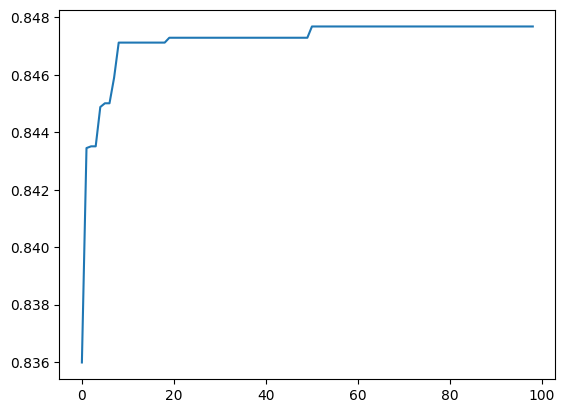

In [59]:
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

Wykres liniowy, który przedstawia zależność między wartościami maxRes a indeksem.

# Inzynieria zmiennych

In [60]:
df= pd.read_csv('healthcare-dataset-stroke-data.csv')

In [61]:
del df['id']

In [62]:
mediana_per_gender = df.groupby('gender')['bmi'].transform('median')

df['bmi'] = df['bmi'].fillna(mediana_per_gender)

Grupowanie zmiennych: 

In [63]:
# Tworzenie przedziałów dla kategorii (bmi)
bins = [0, 16.0, 16.9, 18.5, 24.9, 29.9, 34.9, 39.9, float('inf')]
labels = ['wygłodzenie', 'wychudzenie', 'niedowaga', 'waga_prawidłowa',
          'nadwaga', 'otyłość_I_stopnia', 'otyłość_II_stopnia', 'otyłość_III_stopnia']

# Zamiana wartości na kategorie
df['bmi_cat'] = pd.cut(df['bmi'], bins=bins, labels=labels)

In [64]:
# Tworzenie przedziałów dla kategorii (poziom glukozy we krwi)
bins = [50, 114.9, 179.9, 280.0, float('inf')]
labels = ['excellent', 'good', 'bad','verybad']

# Zamiana wartości na kategorie
df['glucose_level'] = pd.cut(df['avg_glucose_level'], bins=bins, labels=labels)

In [65]:
#podział zmiennej na przedziały
df["age_cut"] = pd.cut(df["age"], [0, 7, 14, 21, 30, 45, 60, 75, 100])

In [66]:
dfrf=df.copy()

In [67]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [68]:
df = pd.get_dummies(df,drop_first=True)

In [69]:
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_cat_wychudzenie,bmi_cat_niedowaga,bmi_cat_waga_prawidłowa,bmi_cat_nadwaga,bmi_cat_otyłość_I_stopnia,bmi_cat_otyłość_II_stopnia,bmi_cat_otyłość_III_stopnia,glucose_level_good,glucose_level_bad,glucose_level_verybad,"age_cut_(7, 14]","age_cut_(14, 21]","age_cut_(21, 30]","age_cut_(30, 45]","age_cut_(45, 60]","age_cut_(60, 75]","age_cut_(75, 100]"
0,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,61.0,0,0,202.21,27.8,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,83.75,27.8,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
5106,81.0,0,0,125.20,40.0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
5107,35.0,0,0,82.99,30.6,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
5108,51.0,0,0,166.29,25.6,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


In [70]:
scaler = StandardScaler()

In [71]:
numFeatures = ['age', 'avg_glucose_level', 'bmi']

In [72]:
df[numFeatures]=scaler.fit_transform(df[numFeatures])
#skalowanie cech numerycznych na podstawie wartości średniej i odchylenia standardowego

In [73]:
features = df.columns.tolist()
features.remove(target)

In [74]:
features1 = [word for word in features if 'age_cut' not in word and 'glucose_level' not in word and 'bmi_cat' not in word]

In [75]:
features1

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [76]:
features2 = [word for word in features if 'glucose_level' not in word and 'bmi_cat' not in word ]#age_cut
features2.remove('age')
(features2)

['hypertension',
 'heart_disease',
 'bmi',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'age_cut_(7, 14]',
 'age_cut_(14, 21]',
 'age_cut_(21, 30]',
 'age_cut_(30, 45]',
 'age_cut_(45, 60]',
 'age_cut_(60, 75]',
 'age_cut_(75, 100]']

In [77]:
features3 = [word for word in features if 'age_cut' not in word and 'glucose_level' not in word]##bmi_cat
features3.remove('bmi')

In [78]:
features4 = [word for word in features if 'bmi_cat' not in word and 'age_cut' not in word] #glucose_level
features4.remove('avg_glucose_level')
(features4)

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'glucose_level_good',
 'glucose_level_bad',
 'glucose_level_verybad']

In [79]:
features5 = features.copy()
features5.remove('bmi')
features5.remove('age')
features5.remove('avg_glucose_level')
(features5)

['hypertension',
 'heart_disease',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'bmi_cat_wychudzenie',
 'bmi_cat_niedowaga',
 'bmi_cat_waga_prawidłowa',
 'bmi_cat_nadwaga',
 'bmi_cat_otyłość_I_stopnia',
 'bmi_cat_otyłość_II_stopnia',
 'bmi_cat_otyłość_III_stopnia',
 'glucose_level_good',
 'glucose_level_bad',
 'glucose_level_verybad',
 'age_cut_(7, 14]',
 'age_cut_(14, 21]',
 'age_cut_(21, 30]',
 'age_cut_(30, 45]',
 'age_cut_(45, 60]',
 'age_cut_(60, 75]',
 'age_cut_(75, 100]']

In [80]:
features6 = [word for word in features if 'age_cut' not in word]
features6.remove('bmi')
features6.remove('avg_glucose_level')
(features6)

['age',
 'hypertension',
 'heart_disease',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'bmi_cat_wychudzenie',
 'bmi_cat_niedowaga',
 'bmi_cat_waga_prawidłowa',
 'bmi_cat_nadwaga',
 'bmi_cat_otyłość_I_stopnia',
 'bmi_cat_otyłość_II_stopnia',
 'bmi_cat_otyłość_III_stopnia',
 'glucose_level_good',
 'glucose_level_bad',
 'glucose_level_verybad']

# REGRESJA LOGISTYCZNA

In [81]:
def CVTest(nFolds = 5, randomState=2023,features =[], debug=False, *args, **kwargs):
    #zdefiniowanie funkcji CVTest z parametrami:
    #nFolds - liczba podziałów (składników) użytych w procedurze walidacji krzyżowej - domyślnie 5
    #randomState - ziarno losowości - kontroluje losowość podziałów w walidacji krzyżowe - dmśln 2023

    # Stworzenie obiektu walidacji krzyżowej i podzielenie zbioru na foldy
    kf = KFold(n_splits = nFolds, shuffle=True, random_state=randomState)
    # Stworzenie listy z wynikami
    trainResults = []
    testResults = []
    predictions = []
    # Pętla do estymacji i walidacji modeli na kolejnych foldach
    for train, test in kf.split(df.index.values):
        
        # Stworzenie modelu
        mod = LogisticRegression(*args, **kwargs,)
        
        # Estymacja
        X = df.iloc[train]
        regresja = mod.fit(X[features],X[target])
        
        # Zapisanie predykcji
        predsTrain = regresja.predict_proba(df.iloc[train][features])[:,1]
        preds = regresja.predict_proba(df.iloc[test][features])[:,1]

         # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Zapisanie wyników ze zbioru walidacyjnego do listy
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)

        # Zapisanie wyników dopasowania w foldach
        trainResults.append(trainScore)
        testResults.append(testScore)

        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions

#podsumowujac kod powyzej:
#tworzy model regresji logistycznej, trenuje go na zbiorze treningowym, 
#wykonuje predykcję dla zbioru treningowego i testowego
#oblicza metrykę AUC-ROC dla obu zbiorów, zapisuje wyniki predykcji oraz wyniki AUC-ROC do odp list


Przeprowadzenie regresji logistycznej dla pierwotnych zmiennych objaśniających - features1:

In [82]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(features=features1, nFolds = 10, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8402619244280355 Valid AUC: 0.8883183568677793
Train AUC: 0.8507288660668817 Valid AUC: 0.7880749784190405
Train AUC: 0.8408223025848478 Valid AUC: 0.8601211689237349
Train AUC: 0.8479611517412204 Valid AUC: 0.775
Train AUC: 0.8417504015346169 Valid AUC: 0.846753918958888
Train AUC: 0.8423660123454504 Valid AUC: 0.8476430976430978
Train AUC: 0.8451150361530632 Valid AUC: 0.8140591589451176
Train AUC: 0.8453182257863832 Valid AUC: 0.8258503401360544
Train AUC: 0.8393448446098086 Valid AUC: 0.8757045675413022
Train AUC: 0.8467918752997188 Valid AUC: 0.8317013463892289
0.8440460640550025 0.8353226933824244


Ostateczne średnie wartości AUC dla zbioru treningowego i walidacyjnego wynoszą odpowiednio 0.8440781263144144 i 0.8351492512562608.
Otrzymane wyniki sugerują, że model ma umiarkowanie dobrą zdolność do predykcji na zbiorze treningowym i zbiorze walidacyjnym. Różnica między średnimi AUC dla obu zbiorów jest niewielka, co może wskazywać na brak nadmiernego dopasowania (overfittingu) lub niedostatecznego dopasowania (underfittingu) modelu.

Wartości AUC w okolicach 0.84-0.85 są ogólnie dobre, ale warto byłoby porównać je z wynikami innych modeli, aby ocenić względną wydajność tego modelu. 

Przeprowadzenie regresji logistycznej po wprowadzeniu grupowania zmiennej AGE - features2:

In [83]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10,features=features2, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8331411028292217 Valid AUC: 0.8859649122807017
Train AUC: 0.8434380835172297 Valid AUC: 0.7831730176347268
Train AUC: 0.8352738748838913 Valid AUC: 0.8369565217391305
Train AUC: 0.842601893461 Valid AUC: 0.738978494623656
Train AUC: 0.8363283922698643 Valid AUC: 0.8250887311446318
Train AUC: 0.8356766636410228 Valid AUC: 0.8362411998775635
Train AUC: 0.8379183201827789 Valid AUC: 0.8095153243050606
Train AUC: 0.837097175563021 Valid AUC: 0.8278425655976677
Train AUC: 0.8315748333313265 Valid AUC: 0.8728862973760934
Train AUC: 0.8398405604254602 Valid AUC: 0.8275842884166018
0.8372890900104816 0.8244231352995834


Porównując te wyniki, można zauważyć, że średnie wartości AUC dla zbioru treningowego i walidacyjnego różnią się nieznacznie - są nieznacznie niższe.

Wcześniej uzyskane średnie wartości AUC wynosiły 0.8440781263144144 dla zbioru treningowego i 0.8351492512562608 dla zbioru walidacyjnego.
Natomiast teraz otrzymane średnie wartości AUC wynoszą 0.8374816449827789 dla zbioru treningowego i 0.823809269089695 dla zbioru walidacyjnego.

Różnice między tymi wynikami są niewielkie, co sugeruje, że zmiana zestawu cech (features) wpływa nieznacznie na wydajność modelu. Model zachowuje zbliżone zdolności predykcyjne na obu zbiorach danych.

Przeprowadzenie regresji logistycznej po wprowadzeniu grupowania zmiennej BMI - features3:

In [84]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10,features=features3, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8427388617433101 Valid AUC: 0.8887462558836116
Train AUC: 0.8529568409438126 Valid AUC: 0.7875508694043655
Train AUC: 0.8440359081977299 Valid AUC: 0.8578047042052744
Train AUC: 0.8499520270997935 Valid AUC: 0.7837365591397849
Train AUC: 0.8453580117783488 Valid AUC: 0.843315587104407
Train AUC: 0.8450021303002796 Valid AUC: 0.8528466483011937
Train AUC: 0.8478024846756747 Valid AUC: 0.8167320028510334
Train AUC: 0.8488512805693025 Valid AUC: 0.8182215743440233
Train AUC: 0.8416105752828652 Valid AUC: 0.8820213799805637
Train AUC: 0.850092021756881 Valid AUC: 0.8254979414710137
0.8468400142347999 0.835647352268527


Porównując te wyniki do pierwotnej formy modelu, można zauważyć, że wprowadzenie kolejnej zmiennej również wpływa nieznacznie na wyniki modelu. Model zachowuje podobne zdolności predykcyjne na obu zbiorach danych.
Trudno tę zmianę nazwać zauważalną poprawą, ale jednocześnie prawdopodobnie nie pogroszyliśmy modelu. W większości przypadków uproszczenie modelu, które nie osłabia jego zdolności predykcyjnej jest skutecznym działaniem.

Przeprowadzenie regresji logistycznej po wprowadzeniu grupowania zmiennej poziomu glukozy - features4:

In [85]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10,features=features4, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8439778279777483 Valid AUC: 0.8920624732563115
Train AUC: 0.8525674758105586 Valid AUC: 0.8008385744234802
Train AUC: 0.8451722051446022 Valid AUC: 0.8579828937990022
Train AUC: 0.8518283549211385 Valid AUC: 0.7724462365591398
Train AUC: 0.84575851284394 Valid AUC: 0.8511904761904762
Train AUC: 0.8451899466292887 Valid AUC: 0.8585858585858586
Train AUC: 0.8494092874821157 Valid AUC: 0.8104062722736993
Train AUC: 0.8492978041076152 Valid AUC: 0.8252672497570457
Train AUC: 0.8438612546006976 Valid AUC: 0.8708454810495627
Train AUC: 0.8501994884799995 Valid AUC: 0.8349838655836208
0.8477262157997704 0.8374609381478197


Porównując te wyniki do pierwotnej formy modelu, można zauważyć, że znowu wprowadzenie kolejnej zmiennej również wpływa nieznacznie na wyniki modelu - widzimy lekką poprawę.

Przeprowadzenie regresji logistycznej po wprowadzeniu grupowania wszystkich zmiennych - features5:

In [86]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10,features=features5, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8437121219660255 Valid AUC: 0.8880509199828841
Train AUC: 0.8511171702597182 Valid AUC: 0.8043840177580466
Train AUC: 0.8449146917225372 Valid AUC: 0.8417676407697792
Train AUC: 0.8525748719906795 Valid AUC: 0.7663306451612903
Train AUC: 0.8486276508002786 Valid AUC: 0.8238317065956818
Train AUC: 0.8437944455764881 Valid AUC: 0.8583945515763697
Train AUC: 0.8487981357849557 Valid AUC: 0.8090253029223093
Train AUC: 0.8485066045346723 Valid AUC: 0.8178814382896015
Train AUC: 0.8431478203630788 Valid AUC: 0.8737123420796891
Train AUC: 0.8485993683764855 Valid AUC: 0.8263046622899743
0.847379288137492 0.8309683227425626


Wyniki pokazują, że w porównaniu do pierwotnej formy modelu różnice między tymi wynikami są niewielkie, co sugeruje, że model zachowuje podobne zdolności predykcyjne na obu zbiorach danych. 
Tak jak powyżej, trudno tę zmianę nazwać zauważalną poprawą, ale jednocześnie prawdopodobnie nie pogroszyliśmy modelu. W większości przypadków uproszczenie modelu, które nie osłabia jego zdolności predykcyjnej jest skutecznym działaniem.

Przeprowadzenie regresji logistycznej po wprowadzeniu grupowania bmi i poziomu glukozy bez age (wprowadzenie grupowania zmiennej age osłabia nieznacznie wyniki) - features6:

In [87]:
trainResults_r1, testResults_r1, predictions_r1 = CVTest(nFolds = 10,features=features6, randomState=2023,debug=True)
print(np.mean(trainResults_r1), np.mean(testResults_r1))

Train AUC: 0.8465871207220834 Valid AUC: 0.8902439024390244
Train AUC: 0.8548219741979292 Valid AUC: 0.7994203970896535
Train AUC: 0.8481363920598848 Valid AUC: 0.8565573770491803
Train AUC: 0.8539881144692142 Valid AUC: 0.7803763440860215
Train AUC: 0.8493552708007335 Valid AUC: 0.8456817509612541
Train AUC: 0.8473891986571904 Valid AUC: 0.8621059075604529
Train AUC: 0.8519677263335552 Valid AUC: 0.8129009265858873
Train AUC: 0.8527194788618767 Valid AUC: 0.8203595724003887
Train AUC: 0.8465193239332603 Valid AUC: 0.8756073858114676
Train AUC: 0.8535244764912493 Valid AUC: 0.8286135529097586
0.8505009076526978 0.8371867116893089


Uzyskane w ten sposób wyniki regresji są (mimo nieznacznej różnicy) najlepszymi wynikami. 
Wcześniej uzyskane średnie wartości AUC wynosiły 0.8440781263144144 dla zbioru treningowego i 0.8351492512562608 dla zbioru walidacyjnego.

Natomiast teraz otrzymane średnie wartości AUC wynoszą 0.8507079140413151 dla zbioru treningowego i 0.837249894206144 dla zbioru walidacyjnego.

Różnice między tymi wynikami są względnie większe niż wcześniej, co sugeruje, że wprowadzenie grupowania dwóch zmiennych - bmi i poziomu glukozy -  przyczyniło się do poprawy wydajności modelu. Model uzyskuje wyższe wartości AUC dla zbioru treningowego i walidacyjnego.

# Random forest

In [88]:
dfrf

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_cat,glucose_level,age_cut
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,otyłość_II_stopnia,bad,"(60, 75]"
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,27.8,never smoked,1,nadwaga,bad,"(60, 75]"
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,otyłość_I_stopnia,excellent,"(75, 100]"
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,otyłość_I_stopnia,good,"(45, 60]"
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,waga_prawidłowa,good,"(75, 100]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,27.8,never smoked,0,nadwaga,excellent,"(75, 100]"
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0,otyłość_III_stopnia,good,"(75, 100]"
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0,otyłość_I_stopnia,excellent,"(30, 45]"
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0,nadwaga,good,"(45, 60]"


In [89]:
catFeatures = ['gender', 'hypertension', 'heart_disease','ever_married','work_type', 'Residence_type', 'smoking_status', 'bmi_cat','glucose_level']

In [90]:
# Słownik zawierachąch mapy
mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy kolumnę (tworzymy mapę) i od razu ją nakładamy na zmienną, na której robiliśmy dopasowanie
    dfrf[feature] = le.fit_transform(dfrf[feature])
    # Zapiszmy mapę, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le

In [91]:
def CVTestRFClass(nFolds = 5, randomState=2023, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfrf.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfrf.iloc[train][features], dfrf.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfrf.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfrf.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(dfrf[target].iloc[train], predsTrain)
        testScore = roc_auc_score(dfrf[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions

In [92]:
features6 = dfrf.columns.tolist()
features6.remove(target)
features6.remove('bmi')
features6.remove('avg_glucose_level')
features6.remove('age_cut')
print(features6)

['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'bmi_cat', 'glucose_level']


In [93]:
# Pętla po parametrze n_estimators
for k in [100, 200,300,350,400, 500,600]:
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=k,features=features6)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

100 0.999782324866388 0.7513185531595182 0.24846377170686973
200 0.9997822993071008 0.75871820044958 0.24106409885752078
300 0.9997818103376407 0.764916931902736 0.23486487843490467
350 0.9997820803816578 0.7667651867851666 0.23301689359649125
400 0.999782324866388 0.7693885820165977 0.2303937428497903
500 0.9997818103376407 0.770540725462989 0.22924108487465167
600 0.9997823248663881 0.7738458394358817 0.22593648543050637


In [94]:
# lizczba zmiennych objaśniających
print(len(features6))

10


In [95]:
import random

results = []  # Przygotujmy listę do zapisywnia wyników

# Teraz napiszmy pętle, w której będziemy iterować kolejne wyszukiwania.
for k in range(200):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(2, 4),
        "max_features" : random.randint(7, 10),
        "min_samples_split" : random.randint(21, 32),
        #"bootstrap": random.choice([True, False]),
        #"min_weight_fraction_leaf": round(random.uniform(0.0,0.54),1),
        #"min_impurity_decrease": round(random.uniform(0.0,0.54),1)
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions = CVTestRFClass(n_estimators=300,
                                                           max_depth=params["max_depth"],
                                                           max_features=params["max_features"],
                                                           min_samples_split=params["min_samples_split"],
                                                           min_samples_leaf=params["min_samples_leaf"],
                                                           features=features6)
                                                           #bootstrap=params["bootstrap"])
                                                           #min_weight_fraction_leaf=params["min_weight_fraction_leaf"],
                                                           #min_impurity_decrease=params["min_impurity_decrease"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy())) 
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("Iteracja",k,"\n Top 1 :", )
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 3, 'max_features': 9, 'min_samples_split': 26, 'min_samples_leaf': 5} 0.8382354207904399
{'max_depth': 3, 'max_features': 10, 'min_samples_split': 29, 'min_samples_leaf': 11} 0.8376893223797317
{'max_depth': 3, 'max_features': 8, 'min_samples_split': 27, 'min_samples_leaf': 1} 0.8381730872527877
{'max_depth': 4, 'max_features': 8, 'min_samples_split': 24, 'min_samples_leaf': 20} 0.8375687048241977
{'max_depth': 3, 'max_features': 7, 'min_samples_split': 28, 'min_samples_leaf': 13} 0.8372806555106018
{'max_depth': 2, 'max_features': 8, 'min_samples_split': 25, 'min_samples_leaf': 14} 0.8339369787320242
{'max_depth': 3, 'max_features': 8, 'min_samples_split': 30, 'min_samples_leaf': 29} 0.8374273570337898
{'max_depth': 4, 'max_features': 10, 'min_samples_split': 25, 'min_samples_leaf': 23} 0.8367135218955719
{'max_depth': 2, 'max_features': 10, 'min_samples_split': 23, 'min_samples_leaf': 19} 0.8333003193491628
{'max_depth': 2, 'max_features': 9, 'min_samples_split': 26, 'm

In [96]:
trainResults, testResults, predictions = CVTestRFClass(n_estimators=300, max_depth=3,max_features=8, min_samples_split=32, min_samples_leaf=5, features=features6)
print(np.mean(trainResults),np.mean(testResults))

0.8623344411739534 0.8384232418708688


In [97]:
def CVTestRFClass(nFolds = 5, randomState=2023, debug=False, features=features, saveModels = False, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    models = []
    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(dfrf.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(dfrf.iloc[train][features], dfrf.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(dfrf.iloc[train][features])[:,1]
        preds = clf.predict_proba(dfrf.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score(dfrf[target].iloc[train], predsTrain)
        testScore = roc_auc_score(dfrf[target].iloc[test], preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        # Zapisanie wyników do listy models
        if saveModels:
            models.append(clf)
        
    return trainResults, testResults, predictions, models

In [98]:
trainResults, testResults, predictions, models = CVTestRFClass(n_estimators=300, max_depth=3,max_features=8, min_samples_split=32, min_samples_leaf=5,saveModels=True, features=features6)

In [99]:
imps = list(zip(models[0].feature_importances_, features6))
imps.sort(reverse=True)
imps

[(0.7807349957944683, 'age'),
 (0.03936118611351765, 'glucose_level'),
 (0.03808871231832581, 'hypertension'),
 (0.03793325973531988, 'ever_married'),
 (0.027473239290931293, 'bmi_cat'),
 (0.020804258244738087, 'heart_disease'),
 (0.020445407455653587, 'work_type'),
 (0.015597881568417401, 'Residence_type'),
 (0.012620249740466924, 'smoking_status'),
 (0.006940809738161156, 'gender')]

In [100]:
imps = list(zip(models[2].feature_importances_, features6))
imps.sort(reverse=True)
imps

[(0.7523384417351701, 'age'),
 (0.056965782817890595, 'hypertension'),
 (0.054597557061283636, 'heart_disease'),
 (0.040329988599788, 'glucose_level'),
 (0.027038294006061492, 'smoking_status'),
 (0.025122193179631814, 'ever_married'),
 (0.019086319954082547, 'bmi_cat'),
 (0.01770100321315871, 'work_type'),
 (0.0036697299257560678, 'gender'),
 (0.0031506895071771305, 'Residence_type')]

# XGB

In [102]:
def run_xgb(train, validate, features, target, # argumenty obowiązkowe
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7, # hiperparametry
            colsample_bylevel=1,lambdaX = 1, alpha=0, gamma=0, min_child_weight=0, # hiperparametry
            rate_drop = 0.2, skip_drop=0.5, # hiperparametry
            num_boost_round = 1000, early_stopping_rounds = 50, # hiperparametry
            debug=True, eval_metric= ["auc"], objective = "binary:logistic", # konfiguracja
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"): # konfiguracja
    '''
    Uniwersalny wrapper dla XGB dla gbtree i dart
    Więcej opcji https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
    
    Parametry
    ----------
    train, validate, features, target : wymagane zmienne bez domyślnych wartości
    train, validate : pd.DataFrames z kolumnami opisanymi w features i target
    features : lista zmiennych do wykorzystania w trenowaniu
    target : nazwa zmiennej objasnianej
    
    --- Zmienne wspólne dla gbtree i dart
        --- Zmienne właściwe dla Ensamble/Boosting
        eta : "learning rate"
        max_depth=7 : maksymalna głębokość drzew [0,∞]
        subsample : udział (0,1] obserwacji do treningu jednej iteracji
        colsample_bytree : udział (0,1] kolumn do treningu jednej iteracji
        colsample_bylevel : udział  (0,1] kolumn na poziom do treningu jednej iteracji
        --- Zmienne regularyzacyjne
        lambdaX=0 : regularyzacja L2 [0,∞]
        alpha=0 : regularyzacja L1 [0,∞]
        gamma=1 : minimalna redukcja funkcji straty
        min_child_weight=0 : minimalna suma wg poddrzewa

    --- Zmienne dla algorytmu dart
    rate_drop : 
    skip_drop : 
    
    --- Zmienne dla XGB, opis/agorytm/liczba drzew etc.
    num_boost_round : maksymalna liczba iteracji
    early_stopping_rounds : margines iteracji dla early stopping
    debug : Czy włączyć pełne opisy.
    eval_metric : Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    objective : reg:linear, reg:logistic, binary:logistic, multi:softmax lub inne Pełna lista dostępna https://github.com/dmlc/xgboost/blob/master/doc/parameter.md 
    seed : random seed
    booster : ‘auto’, ‘exact’, ‘approx’, ‘hist’, ‘gpu_exact’, ‘gpu_hist’- silnik dla drzew gbtree (cart), dart (gbtree z dropoutem) lub gblinear
    tree_method : zobacz http://xgboost.readthedocs.io/en/latest/parameter.html
    grow_policy : depthwise, lossguide
    '''
   
    start_time = time.time()
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 'early_stopping_rounds',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    # Stworzenie słownika do przekazania do XGB
    params = dict()
    for param in paramList:
        params[param]=eval(param)
    if(debug):
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    # Automatyczne przekazanie liczby klas dla wielu poziomów klasyfikacji
    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    params["silent"]=1
    
    # XGB wymaga w słowniku parametrów słowa kluczowego lambda, poniżej workaround
    params["lambda"]=lambdaX
    
    # Przekształcenie zbiorów do struktury DMatrix
    # Struktura danych DMatrix pozwala na efektywne tworzenie drzew
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values)
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values)

    # Stworzenie listy zbiorów do ealuacji
    evals = [(dtrain, 'train'), (dvalid, 'valid')]
    
    # Stworzenie zmiennej słownikowej do przekazania
    train_history = dict()

    # Uruchomienie algorytmu trenującego
    gbm = xgb.train(params, dtrain, 
                    num_boost_round, early_stopping_rounds=early_stopping_rounds,
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    
    # Obliczenai statystyk i dodatkowych wartości
    score = gbm.best_score

    # Przekształcenie historii trenowania do Pandas Data Frame
    trainHistory = dict()
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    train_history = pd.DataFrame(trainHistory)

    # Zapis przewidywanych wartości dla zbioru walidacyjnego dla najlepszej (z punktu widzenia walidacji) iteracji
    trainPred = gbm.predict(dtrain, ntree_limit=gbm.best_iteration)
    testPred = gbm.predict(dvalid, ntree_limit=gbm.best_iteration)

    # Przygotowanie posortowanej listy dla wazności zmiennych, zamaist słownika
    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        # Skorzystanie z wbudowanej funkcji wizualizującej waznośc zmiennych
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    return score, trainPred, testPred, train_history, impFig, imp

In [103]:
#podział zbioru danych na zbiór treningowy i zbiór walidacyjny
test_size = 0.2
X_train, X_valid = train_test_split(dfrf, test_size=test_size, random_state=2023, stratify=dfrf[target].values)

eta 0.03, max_depth 7, subsample 0.7, colsample_bytree 0.7, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 0, min_child_weight 0, num_boost_round 1000, early_stopping_rounds 50, rate_drop 0.2, skip_drop 0.5, eval_metric ['auc'], objective binary:logistic, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 4088
Length valid: 1022
[23:02:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[0]	train-auc:0.64440	valid-auc:0.62078
[1]	train-auc:0.80541	valid-auc:0.84665
[2]	train-auc:0.81004	valid-auc:0.83312
[3]	train-auc:0.82610	valid-auc:0.85204
[4]	train-auc:0.83201	valid-auc:0.85599
[5]	train-auc:0.83969	valid-auc:0.85649
[6]	train-auc:0.83813	valid-auc:0.85583
[7]	train-auc:0.83994	valid-auc:0.85868
[8]	train-auc:0.84515	valid-auc:0.86240
[9]	train-auc:0

/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


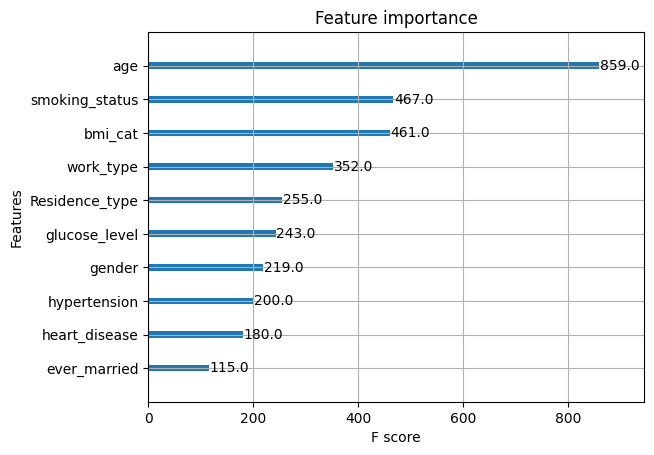

In [104]:
score, trainPred, testPred, train_history, impFig, imp = run_xgb(X_train, X_valid, features6, target, early_stopping_rounds=50)

In [105]:
import random
results=[]
paramList = []
for x in range(100):
    params = (random.randint(3, 9), random.uniform(0.1, 0.9), random.uniform(0.1, 0.9), random.uniform(0, 10), random.uniform(0, 10))
    trainResults, testResults, predictions, hists = CVTestXGB(features=features6,
        max_depth=params[0],
        subsample = params[1],
        colsample_bytree = params[2],
        lambdaX=params[3],
        gamma=params[4])
    print(np.mean(testResults), params)
    results.append(np.mean(testResults))
    paramList.append(params)


[23:03:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8393503536507503 (3, 0.2353850188862916, 0.602477269664173, 5.904836108810951, 7.813290702897959)
[23:03:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8416548806073518 (5, 0.6499200723996699, 0.7210646489326386, 8.126395991324271, 4.940412168115062)
[23:03:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.842620957629291 (7, 0.8401703320287807, 0.5230298951496247, 4.281594092609444, 5.541211461442969)
[23:03:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8408824932150776 (9, 0.7350865569714954, 0.8110789687682705, 4.791095967344054, 3.662462205314786)
[23:03:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8372023708346884 (6, 0.303394022326944, 0.8078990834391291, 2.9701294612240137, 5.279876589119468)
[23:03:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8395916984705554 (3, 0.4986992847153723, 0.4266664724267758, 0.45383853349673875, 3.9846682058083216)
[23:03:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8403522460775678 (7, 0.5019832134371227, 0.6969101148233653, 2.589602699291076, 4.9532071793247745)
[23:03:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8397701209876616 (9, 0.360750374571154, 0.6023532793577513, 8.103985310329719, 1.1186107373584764)
[23:03:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8348451962892962 (7, 0.40590368609225724, 0.507057207991717, 7.63542238425978, 6.315503556281037)
[23:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8224548938054413 (3, 0.5510487535645201, 0.25029172330717764, 0.12327540431585682, 8.408185433484622)
[23:03:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8387765796734745 (5, 0.48702452150192277, 0.6887667964478821, 4.236509592817294, 9.825428553419611)
[23:03:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8362409987842204 (3, 0.2771928194622465, 0.6766647462004294, 5.302120251160605, 8.177034000021695)
[23:03:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8360468081428737 (4, 0.6553188065652453, 0.7393908022796002, 9.619392023434674, 5.573346871494883)
[23:03:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406262768838326 (3, 0.15614864154481342, 0.3963058118040905, 3.9921639404474196, 0.8160816820294858)
[23:03:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8401648668046369 (5, 0.4783866800219879, 0.46981403752133766, 3.4001572412906, 4.25354041713355)
[23:03:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8429461565921746 (3, 0.8324283676209162, 0.43369478673155404, 7.807286270901736, 7.8963282743948255)
[23:03:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8426012360744238 (7, 0.8190543572655474, 0.6015003703543568, 5.698030330286134, 3.48278089849674)
[23:03:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8381983694377588 (4, 0.2313958914356042, 0.8725570086017427, 8.420653221895893, 5.146076437239899)
[23:03:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8375040495054356 (3, 0.1997501711804075, 0.42884308937914895, 8.172927410468368, 8.181206528873625)
[23:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8436139379999922 (4, 0.6820745987190875, 0.5151029560926278, 8.921088495899795, 5.7650461775827715)
[23:03:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8334325174821429 (9, 0.2971832340280849, 0.16777145083948675, 2.9548104168693925, 1.3440253586857154)
[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8433315202089255 (7, 0.14293138946918582, 0.6077844869520657, 8.472908042708939, 0.9046794541098291)
[23:03:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8429185129043963 (8, 0.8795577291769948, 0.5215111951552245, 6.174343298270314, 6.712327036649505)
[23:03:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8389571762012412 (6, 0.3836069010192451, 0.36962220723168715, 2.059334011817625, 4.247852805054681)
[23:03:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8414628065738169 (8, 0.30842541929264533, 0.5181561528568502, 1.8976969517038267, 5.46816551274631)
[23:03:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406128464834953 (4, 0.44689056388065207, 0.43168681008430654, 9.117309648272112, 1.4150966293811562)
[23:03:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8420154602821419 (4, 0.38232992528306853, 0.5665769033828584, 6.053137399017579, 3.5141650824909654)
[23:03:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8357465176014998 (4, 0.23888234878329362, 0.17002132653602792, 7.027077441942088, 3.879673594837584)
[23:03:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8371100748372833 (5, 0.257656833470695, 0.7244734591597936, 5.31801209164199, 2.1358157753821496)
[23:03:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8356663571689926 (6, 0.42356438556213305, 0.8348741311216682, 4.892343808986985, 8.379433331354425)
[23:03:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8374644715081818 (3, 0.7174397423196649, 0.8215576195989809, 9.402217720184497, 2.3783673313701046)
[23:03:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.836100317301151 (9, 0.7824005063279682, 0.3339398754201718, 5.706943059017844, 0.2339895525803415)
[23:03:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:03:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8390953262689018 (6, 0.6117133742068215, 0.2535890126135142, 1.8670748816686578, 4.150980316669017)
[23:03:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.839394966628238 (5, 0.8205421696918285, 0.7517361407149757, 3.0651954744569676, 9.228125485068082)
[23:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:03:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8411091052694986 (4, 0.7914925013401011, 0.35071497386955797, 2.83482109760178, 4.797595531937811)
[23:04:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8363498534983904 (5, 0.33188252521571415, 0.7173496314587363, 0.4921225085750758, 6.13566171969726)
[23:04:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8400945343030578 (4, 0.1482443074993036, 0.8118899756189588, 1.8635102882184507, 4.147093949913911)
[23:04:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8403347715176073 (5, 0.4224678625371736, 0.6073728694151912, 2.9451272956452335, 6.883886454243217)
[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8344694525839532 (7, 0.6896376450586275, 0.6849126239685006, 0.5710135919393167, 0.9139387945063004)
[23:04:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8403406508189682 (4, 0.20034257570751077, 0.5176278275865253, 4.932206271942841, 5.615295890006719)
[23:04:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8383033072323274 (5, 0.8249092493757518, 0.8960156961975114, 2.7430425095629007, 7.936176961563546)
[23:04:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8408744944784479 (9, 0.10738550763594744, 0.48533713912903365, 0.6261701828639932, 2.3474817864600803)
[23:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8380222414994591 (8, 0.5506903990675317, 0.3655692622090756, 5.4163038019060386, 5.573683444256391)
[23:04:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8433671434633236 (8, 0.7158027241966661, 0.20143250984511418, 1.5974567701075082, 6.510176800042315)
[23:04:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.838904466191096 (7, 0.6321802022739371, 0.21919395812969872, 7.239592076360534, 3.116897002278817)
[23:04:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.830962911790855 (8, 0.6877804304861422, 0.12406509490421797, 7.822894524570856, 1.865330871893791)
[23:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8398645571037042 (4, 0.8201709107929125, 0.3378754955939671, 4.8837497892011505, 4.040457780133632)
[23:04:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8356798845837933 (4, 0.8581106028697286, 0.28315412389823524, 3.7517617832527472, 0.4538026866622291)
[23:04:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8321732838192111 (8, 0.13199454309628714, 0.5161206701009966, 7.2416269630859, 5.839099907686004)
[23:04:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8432479709749089 (4, 0.507881225340625, 0.5807231549566375, 9.644955449936043, 2.1416759383345196)
[23:04:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8382687534904504 (3, 0.4909730242922824, 0.2864696787779758, 6.723411195728536, 6.990017191295755)
[23:04:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8427488259967408 (5, 0.7343702754460856, 0.339125578262751, 4.866376192248868, 9.597926266299325)
[23:04:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8280689356506571 (6, 0.12561196651657341, 0.7501914243442289, 9.348301568865832, 7.468772388023009)
[23:04:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8423938114598617 (5, 0.728818067827443, 0.4323896748081525, 2.095575175512651, 9.027031769117892)
[23:04:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.840939555769008 (7, 0.6690869513388594, 0.5977428205020721, 4.023037038511292, 5.477385477458947)
[23:04:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8428917073410972 (5, 0.8454628574700517, 0.39487569697354796, 5.807617290162153, 8.639663400811905)
[23:04:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8413283359576512 (7, 0.8179267145313607, 0.3976795617744412, 6.024286528589665, 8.837566603023841)
[23:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8290080126038815 (8, 0.8994508959979737, 0.1414577859508997, 5.349409312715629, 5.583457338702422)
[23:04:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8385327582034172 (6, 0.7007831077448219, 0.8994227134069751, 6.932110369101501, 9.600758364826747)
[23:04:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8365431564005498 (6, 0.8884299715726164, 0.7739318969900726, 5.349838280017508, 0.8325449999637113)
[23:04:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8386357507645856 (4, 0.48027780662022834, 0.8316859894794089, 3.6409084168468766, 9.289558383638477)
[23:04:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8396387204878639 (5, 0.30007404955648953, 0.6565454654093605, 1.4118646576380711, 8.269253776535118)
[23:04:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8417631501807172 (4, 0.8174135507752143, 0.4579243975386428, 7.273027443537309, 5.006826843500537)
[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406538579646131 (3, 0.7504703004860266, 0.8760392353469301, 1.8953968712616998, 5.342433389334377)
[23:04:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8427672620902185 (8, 0.1251033354370728, 0.5313482423859908, 7.412484653977826, 1.0448173241962155)
[23:04:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8334556477810875 (7, 0.38399297847300196, 0.19861251583874956, 8.947188001527755, 9.43119701341442)
[23:04:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8392502940543313 (6, 0.25243346858854765, 0.3256487612050276, 6.521185033770572, 0.7492149460939979)
[23:04:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8391118280422833 (5, 0.33878261169440793, 0.21681240864721707, 0.15613379870741184, 4.296178346120904)
[23:04:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8222009206060326 (7, 0.12510282597547404, 0.5151468276430697, 6.460802836801033, 9.904018759471247)
[23:04:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8224283683737198 (3, 0.6085643681389201, 0.18579609220749732, 3.2201961681820137, 1.8667681612742515)
[23:04:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8393325420829207 (3, 0.7679762403203948, 0.6000391065556452, 7.819738802583469, 8.536973709524156)
[23:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:04:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:04:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8381894997743036 (4, 0.42575634336014545, 0.47200357544696525, 2.6964168247639675, 2.0301959639363956)
[23:04:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8386176838311681 (6, 0.7920599174719137, 0.253499985235634, 6.622945616609536, 5.857584442565154)
[23:05:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8398287676620637 (4, 0.7423627023566302, 0.8488564278332923, 7.572323352693914, 7.039824331327882)
[23:05:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8295001025997472 (8, 0.16059850215667348, 0.5444002290835815, 8.667831204649207, 8.060132364445137)
[23:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8401303455591433 (8, 0.1672957293615333, 0.37052080368845874, 0.8171601394147376, 1.0227537153786337)
[23:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8394880660617234 (5, 0.3088632274431682, 0.3893142614406574, 1.2124790292821308, 1.8831509188467355)
[23:05:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8401227711939315 (3, 0.8582472010549124, 0.7924750100538483, 2.9774149584199017, 2.007574199160227)
[23:05:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8317842260419257 (5, 0.2561277005128886, 0.12612058856880282, 4.608578615167236, 9.930080122118525)
[23:05:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8389693343412101 (7, 0.23486768188750837, 0.8934945536798932, 3.3185495735647663, 4.59782032160026)
[23:05:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8402632527557511 (3, 0.7888094717169076, 0.5808276114352329, 9.287487546313653, 8.359046272767959)
[23:05:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.835189170568172 (5, 0.5054981249968005, 0.10112189333915148, 4.720386478874794, 6.143572897336998)
[23:05:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8406903756425124 (6, 0.10507934038806672, 0.45928928096259936, 3.798928248831851, 2.0321368484689515)
[23:05:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8399242196917067 (8, 0.8401339968511178, 0.7565767354481275, 8.441479834970053, 2.0037703932658832)
[23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8316302702727494 (8, 0.5628284179538986, 0.191096864592285, 3.2397375238388038, 5.529060596745847)
[23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8389431701058527 (4, 0.22017989937997529, 0.42360359929110813, 3.9443941266941698, 1.1872336407242845)
[23:05:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.842064288854966 (7, 0.41233772579586037, 0.6921362259856321, 4.703227715644285, 4.870707082890734)
[23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8311443290610241 (9, 0.5177637645597685, 0.1487777911727343, 8.591082826184412, 0.7321216018092402)
[23:05:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8384416062101525 (5, 0.5349157189620855, 0.4986982297386521, 7.2126225678956235, 9.4010290378816)
[23:05:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8422275946259564 (8, 0.5132000854504642, 0.43942364977190695, 9.762369125940292, 4.0285408045932005)
[23:05:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8322921351728546 (7, 0.36071871193261584, 0.5159114416051412, 9.652134417474477, 8.876917122558925)
[23:05:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8330803950586269 (4, 0.6609071074847968, 0.1380525597386889, 7.060815109150146, 5.508925236893052)
[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8372582494357703 (8, 0.6026230773997724, 0.35918327716747145, 4.166447993759813, 0.41072389526047415)
[23:05:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8404048415169882 (3, 0.478691732473573, 0.8094428810657064, 9.36686321527363, 3.015515415121656)
[23:05:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8396087871376313 (5, 0.801578084328331, 0.6635492886650247, 7.7030669836246615, 6.887163079941092)
[23:05:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8386090633551891 (5, 0.2404557796687711, 0.6212147006180302, 1.2686629213740042, 4.152895019498324)
[23:05:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8404078668303303 (5, 0.27233955254907133, 0.8162553694229778, 9.50779788290653, 4.143925053415302)
[23:05:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.841188014432437 (7, 0.5525637111858169, 0.5006520930791367, 7.4574124547435545, 6.334930975128884)
[23:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

[23:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8348221216710133 (7, 0.5968027012324695, 0.35503479172292896, 2.6139959831063053, 0.03123259988559779)
[23:05:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.



/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[23:05:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping_rounds", "lambdaX", "num_boost_round", "rate_drop", "silent", "skip_drop" } are not used.

0.8357583335817391 (8, 0.14844137366727175, 0.5410611073781367, 1.7616051648933884, 9.565555470796847)


/Users/remigiuszsmigielski/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [106]:
maxRes = []
for i in range(1, len(paramList)):
    maxRes.append(max(results[0:i]))
imp = list(zip(results, paramList))
imp.sort(reverse=True)
for row in imp[0:10]:
    print(row)

(0.8436139379999922, (4, 0.6820745987190875, 0.5151029560926278, 8.921088495899795, 5.7650461775827715))
(0.8433671434633236, (8, 0.7158027241966661, 0.20143250984511418, 1.5974567701075082, 6.510176800042315))
(0.8433315202089255, (7, 0.14293138946918582, 0.6077844869520657, 8.472908042708939, 0.9046794541098291))
(0.8432479709749089, (4, 0.507881225340625, 0.5807231549566375, 9.644955449936043, 2.1416759383345196))
(0.8429461565921746, (3, 0.8324283676209162, 0.43369478673155404, 7.807286270901736, 7.8963282743948255))
(0.8429185129043963, (8, 0.8795577291769948, 0.5215111951552245, 6.174343298270314, 6.712327036649505))
(0.8428917073410972, (5, 0.8454628574700517, 0.39487569697354796, 5.807617290162153, 8.639663400811905))
(0.8427672620902185, (8, 0.1251033354370728, 0.5313482423859908, 7.412484653977826, 1.0448173241962155))
(0.8427488259967408, (5, 0.7343702754460856, 0.339125578262751, 4.866376192248868, 9.597926266299325))
(0.842620957629291, (7, 0.8401703320287807, 0.5230298951

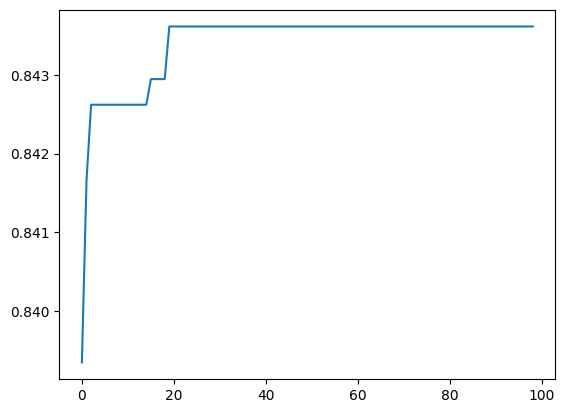

In [107]:
plt.plot(list(range(len(results)-1)), maxRes)
plt.show()

# Podsumowanie

Regresja logistyczna 1 (Lasso): 0.8485007908906512

Regresja logistyczna 2: 0.8505009076526978

RF1: 0.8421891003549359

RF2: 0.8384232418708688

XGB1: 0.8476820138877574

XGB2: 0.8436139379999922